# <span style='color:blue'>Statistical Foundations of ML Project</span>

This project was completed by:
- Cedric Lorenz (0625217), Erasmus+ Student M. Sc. Computer Science
- Kwinten Geeraerts (0546749), M. Ig. Computer Science: AI
- Sean Scofield (0613347), M. Ig. Computer Science: AI

In this Notebook, we seek to answer 3 ml research questions using both synthetic and real-world datasets, as well as various ml model types that we compare (for descriptions of these models, refer to the **Appendix** at the end of this Notebook).
  
While each question has its own section in this Notebook, here is an overview of them:

1. <span style='color:green'>Is cross-validation still a good estimator for the out-of-sample error when using mislabeled data to train, and would the leave-one-out strategy still be the best strategy with mislabeled data?</span>
  
  
2. <span style='color:green'>How susceptible are the different models to the phenomenon of overfitting and how do the model hyperparameters influence it?</span>
  
  
3. <span style='color:green'>For the datasets and ML algorithms used, how does using “bootstrap aggregation” affect the in-sample & out-of-sample error?</span>

# <span style='color:blue'>Research Question #1</span>



## Overview

### Research Question

For this question, we will use _Decision Tree Classifiers_ & _KNN Classifiers_ with a synthetically generated dataset.

To be able to observe general trends at critical points, we will use the following _mislabeling percentages_:
- 0%
- 2.5%
- 5%
- 7.5%
- 10%
- 15%
- 20%
- 25%
- 30%
- 35%
- 40%
- 45%
- 50%

The **research question** we seek to answer is:

_<center><span style='color:green'>Is cross-validation still a good estimator for the out-of-sample error when using mislabeled data to train, and would the leave-one-out strategy still be the best strategy with mislabeled data?</span></center>_

### Strategy

To answer this question we will perform the following steps:
```
1. Repeat 100 times for each mislabeling percentage, for each model type
    1. Add the desired mislabeling to the training dataset
    2. Perform a train-test split on this mislabeled dataset
    3. Use the training data to train 1 model
    4. Get the accuracy score when classifying the testing data
    5. Estimate the out-of-sample accuracy when using this model
    6. Get the accuracy score when using the Leave-One-Out cross-validation strategy
    7. Get the accuracy when using 10 folds in the cross-validation strategy
    8. Get the accuracy when using 5 folds in the cross-validation strategy
    9. Get the accuracy when using 2 folds in the cross-validation strategy
2. Visualize the results to notice trends
3. Perform a T-test on these results to try and reject the null hypothesis
```

To estimate _out-of-sample_ accuracy, we will score the performance of our models on "test" data that has not been used for training.

To make sure we keep the results as objective as possible, the following _hyperparameters_ will be _fixed_ for **each** itteration of the experiment:

**KNN:**
- K = $\sqrt{N}$

**DT's:**
- Maximum depth = 5
    - This value was choosen to avoid overfitting, as the data is not very complex.

### Hypotheses

We hypothesize the following:
1. Mislabeling will only have a **small impact** on cross-validation's ability to accuratly estimate the _out-of-sample_ accuracy.
2. The **Leave-One-Out** strategy will remain the best strategy to estimate the _out-of-sample_ accuracy.
3. Decision trees will be more susceptible to _out-of-sample_ drops in accuracy due to training on mislabeled data.

## Setup


### Imports and helper functions


In [ ]:
from io import BytesIO
import os
import requests
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from tqdm import tqdm

We need a way to easily mislabel our dataset by a given percentage. To achieve this we wil randomly select a number of inidices from the dataset and alter its classifications.

In [ ]:
def mislabel_dataset(y, mislabel_percentage):
    """
    Function to mislabel the dataset.

    Arguments:
        y: Label data as NumPy-type array
        mislabel_percentage: a number in [0, 1] representing the fraction of the dataset that needs to be mislabeled
    """
    samples = len(y)
    mislabel_amount = round(samples * mislabel_percentage) # Amount of samples that need to be mislabeled (rounded)
    unique_classes = np.unique(y) # Amount of unique class-labels present in dataset
    y_copy = y.copy()

    mislabeled_idx = np.random.choice(samples, mislabel_amount, replace=False) # Get the indicies for the datapoints that will be mislabeled, random with no replacement
    for idx in mislabeled_idx: # Give each datapoint at idx a class-label it does not currently have
        original = y_copy[idx]
        incorrect_classes = unique_classes[unique_classes != original]
        new = np.random.choice(incorrect_classes)
        y_copy[idx] = new

    return y_copy

Sklearn does not have an easy built in way to use the Leave-One-Out strategy, for this we add a helper function that streamlines the process for this.

In [ ]:
def CV(X, y, cv, model):
    """
    This function runs a cross-validation using a given model, and returns the scores from this cross-validation

    Arguments:
        X: Feature data as NumPy-type array
        y: Label data as a NumPy-type array
        cv: The amount of folds the cross-validation needs to perform, iff cv = 1 it will use the Leave-One-Out strategy
        model: A pre-trained model
    """
    if cv == 1:
        cv = LeaveOneOut()
    cv_scores = cross_val_score(model, X, y, cv=cv, n_jobs=12)

    return cv_scores

We also implement some helper functions to streamline the experiment process, allowing us to only have to change the essential variables (mislabeling percentage and amount of experiments).

In [ ]:
def run_KNN_experiment(X, y, mislabeling, experiment_amount):
    """
    Runs the same experiment an amount of times for the KNN model. It returns the accuracies as described in the strategy
    section in a NumPy-type array of size (6, experiment_amount)

    Arguments:
        X: Feature data as NumPy-type array
        y: Label data as a NumPy-type array
        mislabeling: a number in [0, 1] representing the fraction of the dataset that needs to be mislabeled
        experiment_amount: The amount of times this experiment needs to be repeated
    """
    results = np.zeros((6, experiment_amount))
    k = round(np.sqrt(len(y)))
    for n in tqdm(range(0, experiment_amount)):
        altered_y = mislabel_dataset(y, mislabeling)
        X_Training, X_Testing, y_Training, y_Testing = train_test_split(X, altered_y, test_size=0.2)

        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_Training, y_Training)

        results[0][n] = accuracy_score(y_Testing, knn.predict(X_Testing))
        results[1][n] = accuracy_score(y_Scoring, knn.predict(X_Scoring))
        knn = KNeighborsClassifier(n_neighbors = k)
        results[2][n] = np.mean(CV(X_Training, y_Training, 1, knn))
        knn = KNeighborsClassifier(n_neighbors = k)
        results[3][n] = np.mean(CV(X_Training, y_Training, 10, knn))
        knn = KNeighborsClassifier(n_neighbors = k)
        results[4][n] = np.mean(CV(X_Training, y_Training, 5, knn))
        knn = KNeighborsClassifier(n_neighbors = k)
        results[5][n] = np.mean(CV(X_Training, y_Training, 2, knn))
    return results

In [ ]:
def run_DT_experiment(X, y, mislabeling, experiment_amount):
    """
    Runs the same experiment an amount of times for the DT model. It returns the accuracies as described in the strategy
    section in a NumPy-type array of size (6, experiment_amount)

    Arguments:
        X: Feature data as NumPy-type array
        y: Label data as a NumPy-type array
        mislabeling: a number in [0, 1] representing the fraction of the dataset that needs to be mislabeled
        experiment_amount: The amount of times this experiment needs to be repeated
    """
    results = np.zeros((6, experiment_amount))
    for n in tqdm(range(0, experiment_amount)):
        altered_y = mislabel_dataset(y, mislabeling)
        X_Training, X_Testing, y_Training, y_Testing = train_test_split(X, altered_y, test_size=0.2)

        dt = tree.DecisionTreeClassifier(max_depth=5)
        dt.fit(X_Training, y_Training)

        results[0][n] = accuracy_score(y_Testing, dt.predict(X_Testing))
        results[1][n] = accuracy_score(y_Scoring, dt.predict(X_Scoring))
        dt = tree.DecisionTreeClassifier(max_depth=5)
        results[2][n] = np.mean(CV(X_Training, y_Training, 1, dt))
        dt = tree.DecisionTreeClassifier(max_depth=5)
        results[3][n] = np.mean(CV(X_Training, y_Training, 10, dt))
        dt = tree.DecisionTreeClassifier(max_depth=5)
        results[4][n] = np.mean(CV(X_Training, y_Training, 5, dt))
        dt = tree.DecisionTreeClassifier(max_depth=5)
        results[5][n] = np.mean(CV(X_Training, y_Training, 2, dt))
    return results

The decision boundaries for the different settings might be needed to argue about the results.

In [ ]:
def plot_decision_boundaries(X, y, model):
    """
    Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting
    the model as we need to find the predicted value for every point in
    scatter plot.

    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model: A pre-trained model
    """
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("Feature-1",fontsize=15)
    plt.ylabel("Feature-2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

### Synthetic Dataset

Now, let's create a synthetic dataset for classification. To do so, we will _first_ generate a distribution of 50k data points, and then select 10k (20%) of these for training purposes. This allows for a large sample to train and test models with, while keeping an even larger sample to accuratly predict the _out-of-sample_ accuracy.

We will generate a distribution that with 2 features and 2 classes, and we will have them be _somewhat_ linearly separable, albeit with overlap:

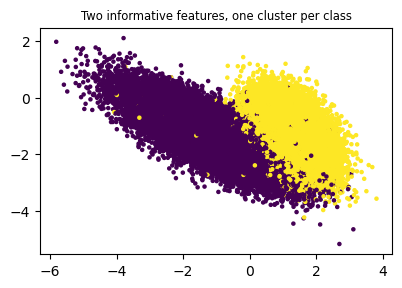

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(322)
plt.title("Two informative features, one cluster per class", fontsize="small")
X, y = make_classification(
    n_samples=50000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, class_sep=1.3, random_state=20
)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=5)
X, X_Scoring, y, y_Scoring = train_test_split(X, y, test_size=0.8, random_state=42)

## Performing our experiment

### Getting data without running experiments

Due to the nature of the Leave-One-Out cross-validation strategy, experiments can take a very long time (6-8 hours using 14 parrallel cores for 100 experiments of each type). For this reason we have a github repository with a set of these results already present. Running the following code-block will download and place this data in the correct folder to continue running the rest of the notebook. **If you choose to do this, you can skip the section "Getting data by running experiments".**(_It will place 26 csv-files in ./results, assuming the notebook is ran using Jupyter_)

In [ ]:
zip_url = "https://github.com/seanscofield/sfml-project/raw/main/experiment_results/q1_results.zip"
zip_file = requests.get(zip_url)
zip_file.raise_for_status()
KNN_experiment_amount = 100
DT_experiment_amount = 100

with zipfile.ZipFile(BytesIO(zip_file.content)) as zip_ref:
    zip_ref.extractall(os.getcwd())

### Getting data by running experiments (**You can skip this part if you have already loaded in the data using the github repository!**)

First decide how many experiments of each type you wish to run.

In [ ]:
KNN_experiment_amount = 100
DT_experiment_amount = 100

Next we need to make sure the folder where the data will be stored has been created.

In [ ]:
folder_path = os.path.join(os.getcwd(), 'results')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Now we can run all the experiments and store the results in the correct folder. (**This step takes 6-8 hours using 14 parrallel cores for 100 experiments of each type!**)

In [ ]:
file_path = os.path.join(os.getcwd(), 'results/KNN_0.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_025.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.025, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_05.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.05, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_075.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.075, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_1.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.1, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_15.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.15, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_20.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.20, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_25.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.25, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_30.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.30, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_35.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.35, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_40.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.40, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_45.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.45, KNN_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/KNN_0_5.csv')
pd.DataFrame(run_KNN_experiment(X, y, 0.5, KNN_experiment_amount)).to_csv(file_path, index=False)

file_path = os.path.join(os.getcwd(), 'results/DT_0.csv')
pd.DataFrame(run_DT_experiment(X, y, 0, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_025.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.025, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_05.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.05, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_075.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.075, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_1.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.1, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_15.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.15, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_20.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.20, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_25.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.25, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_30.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.30, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_35.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.35, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_40.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.40, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_45.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.45, DT_experiment_amount)).to_csv(file_path, index=False)
file_path = os.path.join(os.getcwd(), 'results/DT_0_5.csv')
pd.DataFrame(run_DT_experiment(X, y, 0.5, DT_experiment_amount)).to_csv(file_path, index=False)

## Results

### Graphs

To get a visual indication of the trends our experiments result in, we will benchmark the accuracy of our different methods for each of the mislabeling percentages.
For this we will first load in the data we have collected.

In [ ]:
mislabel_data_points = ['0', '0_025', '0_05', '0_075', '0_1', '0_15', '0_20', '0_25', '0_30', '0_35', '0_40', '0_45', '0_5']

knn_loaded = np.zeros((6, 13))
for x, dp in enumerate(mislabel_data_points):
    file_path = os.path.join(os.getcwd(), 'results/KNN_{}.csv'.format(dp))
    result = np.loadtxt(file_path, delimiter=',')[1:]
    for z in range(0, 6):
        knn_loaded[z][x] = np.mean(result[z])

In [ ]:
mislabel_data_points = ['0', '0_025', '0_05', '0_075', '0_1', '0_15', '0_20', '0_25', '0_30', '0_35', '0_40', '0_45', '0_5']

dt_loaded = np.zeros((6, 13))
for x, dp in enumerate(mislabel_data_points):
    file_path = os.path.join(os.getcwd(), 'results/DT_{}.csv'.format(dp))
    result = np.loadtxt(file_path, delimiter=',')[1:]
    for z in range(0, 6):
        dt_loaded[z][x] = np.mean(result[z])

Now we will plot the data. In these plots the lines represented are as follows:
- Test data: This is the accuracy score when testing the trained model with the remaining test-data after the train-test split
- Scoring data: This is the accuracy when using the 40k unused datapoints from the original dataset of size 50k
- LOO: This is the estimated accuracy when using the _Leave-One-Out_ cross-validation strategy
- 10 folds: This is the estimated accuracy when using _10 folds_ in a cross-validation
- 5 folds: This is the estimated accuracy when using _5 folds_ in a cross-validation
- 2 folds: This is the estimated accuracy when using _2 folds_ in a cross-validation

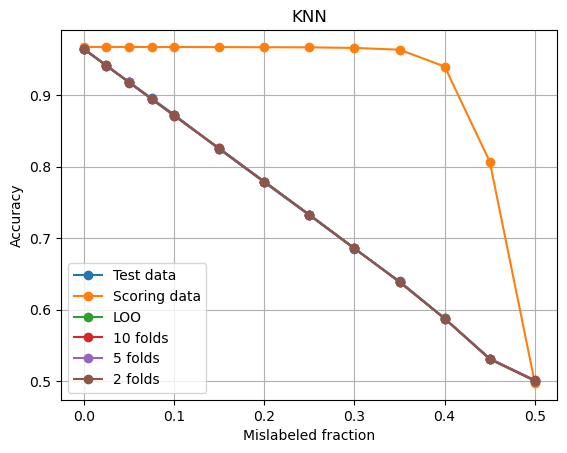

In [ ]:
x_values = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
y_values = knn_loaded

plt.plot(x_values, y_values[0], label='Test data', marker='o')
plt.plot(x_values, y_values[1], label='Scoring data', marker='o')
plt.plot(x_values, y_values[2], label='LOO', marker='o')
plt.plot(x_values, y_values[3], label='10 folds', marker='o')
plt.plot(x_values, y_values[4], label='5 folds', marker='o')
plt.plot(x_values, y_values[5], label='2 folds', marker='o')

# Add labels and legend
plt.xlabel('Mislabeled fraction')
plt.ylabel('Accuracy')
plt.title('KNN')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

From this plot, we can make the following visual observations:
- The accuracy scores from the test data lines up almost perfectly with the resulting scores from all the cross-validation strategies
- The accuracy when using the _scoring data_ remains unexpectedly high up until a mislabeling percentage of about 40%, after which it drops fast

We can draw the following conclusions from these observations:
- Cross-validation does not appear to give a decent estimation for the _out-of-sample_ accuracy, as it generally is very wrong in its prediction.
- KNN appears to be very robust against mislabeling, for this size of k and this dataset, only noticably falling in accuracy after more than 35% of the training-data has been mislabeled.

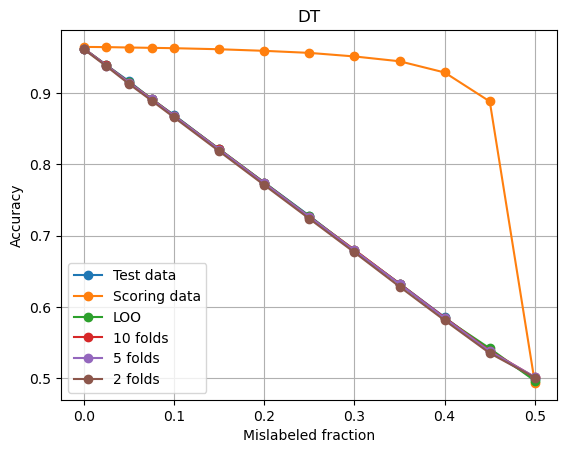

In [ ]:
x_values = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
y_values = dt_loaded

plt.plot(x_values, y_values[0], label='Test data', marker='o')
plt.plot(x_values, y_values[1], label='Scoring data', marker='o')
plt.plot(x_values, y_values[2], label='LOO', marker='o')
plt.plot(x_values, y_values[3], label='10 folds', marker='o')
plt.plot(x_values, y_values[4], label='5 folds', marker='o')
plt.plot(x_values, y_values[5], label='2 folds', marker='o')

# Add labels and legend
plt.xlabel('Mislabeled fraction')
plt.ylabel('Accuracy')
plt.title('DT')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

From this plot, we can make the following visual observations:
- The accuracy scores from the test data still lines up almost perfectly with the resulting scores from all the cross-validation strategies, but appears to have slightly more variation when compared with KNN.
- The accuracy when using the _scoring data_ remains unexpectedly high up until a mislabeling percentage of about 45%, after which it drops fast

We can draw the following conclusions from these observations:
- Cross-validation does not appear to give a decent estimation for the _out-of-sample_ accuracy, as it generally is very wrong in its prediction.
- DT appears to be very robust against mislabeling, for this tree-depth and this dataset, only noticably falling in accuracy after more than 30% of the training-data has been mislabeled.

### Decision Boundaries

It might be interesting to look at the decision bounderies for mislabeled vs non-mislabeled data, as this could potentially show the models' robustness' againts this. (for these specific hyperparameters and dataset)

We first take a look at the decision boundary without any mislabeling:

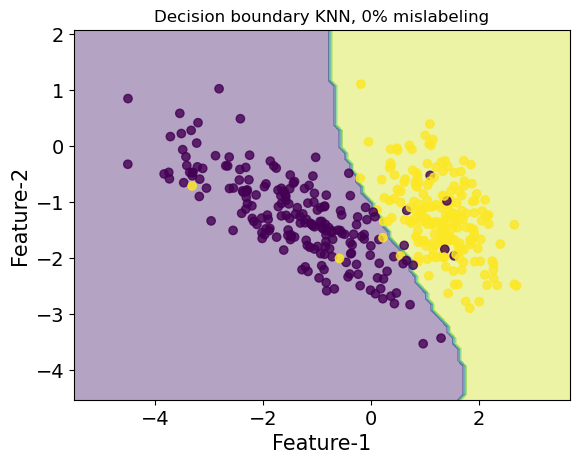

In [ ]:
X_Training, X_Testing, y_Training, y_Testing = train_test_split(X, y, test_size=0.2, random_state=42)

k = round(np.sqrt(len(y)))
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_Training, y_Training)
X_Show, X_Rest, y_Show, y_Rest = train_test_split(X_Training, y_Training, test_size=0.95, random_state=42)
plt = plot_decision_boundaries(X_Show, y_Show, knn)
plt.title("Decision boundary KNN, 0% mislabeling")
plt.show()

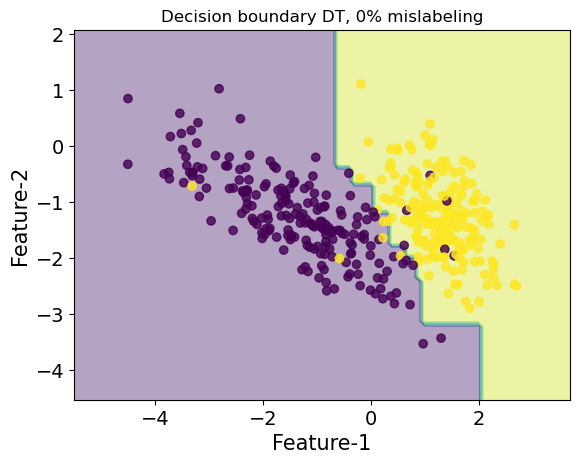

In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_Training, y_Training)
plt = plot_decision_boundaries(X_Show, y_Show, dt)
plt.title("Decision boundary DT, 0% mislabeling")
plt.show()

Now we do the same, but we mislabel the data 25% to see what impact this has on the boundary

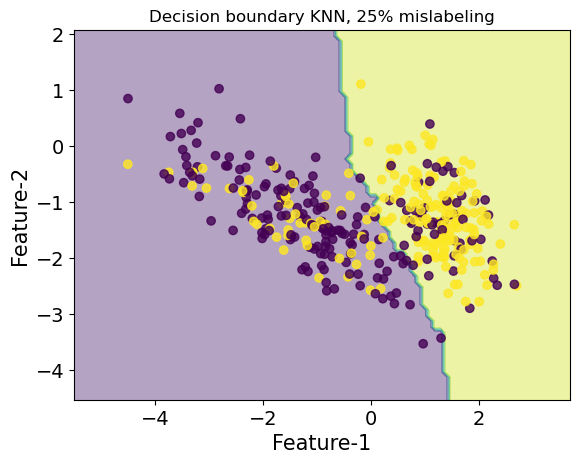

In [ ]:
altered_y = mislabel_dataset(y, 0.25)
X_Training, X_Testing, y_Training, y_Testing = train_test_split(X, altered_y, test_size=0.2, random_state=42)

k = round(np.sqrt(len(y)))
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_Training, y_Training)
X_Show, X_Rest, y_Show, y_Rest = train_test_split(X_Training, y_Training, test_size=0.95, random_state=42)
plt = plot_decision_boundaries(X_Show, y_Show, knn)
plt.title("Decision boundary KNN, 25% mislabeling")
plt.show()

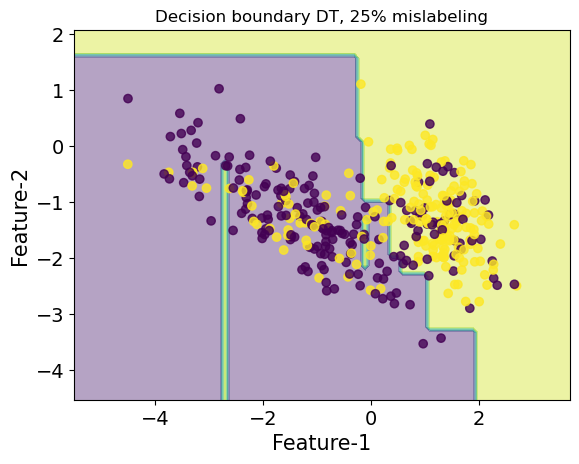

In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_Training, y_Training)
plt = plot_decision_boundaries(X_Show, y_Show, dt)
plt.title("Decision boundary DT, 25% mislabeling")
plt.show()

We notice that the decision boundaries remain largely the same, confirming our suspission about the robustness of both KNN and DT's against mislabeling. (In this specific scenario)

### T-Test

To disprove the null-hypotheses we will run T-tests, comparing the results to show if there are significant enough differences.

For the T-tests we will use the following variables:
- &alpha; = 0.05
- Degrees of freedom = 99 (#experiments - 1)

This results in the critical value for the t-score becoming 1.984

In [ ]:
alpha = 0.05
df = KNN_experiment_amount - 1
critical_p_value = 0.05
critical_t_value = stats.t.ppf(1 - alpha/2, df)

Next we compare all the accuracy scores for a specific mislabeling percentage and model using the T-test.

In [ ]:
# Determine if difference is significant KNN
mislabel_data_points = ['0', '0_025', '0_05', '0_075', '0_1', '0_15', '0_20', '0_25', '0_30', '0_35', '0_40', '0_45', '0_5']
KNN_significance_matrix = np.empty((13, 6, 6), dtype=object)
KNN_tscore_matrix = np.empty((13, 6, 6), dtype=float)
for x, dp in enumerate(mislabel_data_points):
    filepath = os.path.join(os.getcwd(), 'results/KNN_{}.csv'.format(dp))
    loaded = np.loadtxt(filepath, delimiter=',')[1:]
    for y in range(0, 6):
        for z in range(0, 6):
            res = ""
            tscore = 0
            if y != z:
                t_statistic, p_value = stats.ttest_rel(loaded[y], loaded[z])
                t_statistic = abs(t_statistic)
                tscore = t_statistic
                if t_statistic > critical_t_value:
                    res = "Significant difference"
                else:
                    res = "No statistical significant difference"
            else:
                res = "Self"
            KNN_tscore_matrix[x][y][z] = tscore
            KNN_significance_matrix[x][y][z] = res

In [ ]:
# Determine if difference is significant DT
mislabel_data_points = ['0', '0_025', '0_05', '0_075', '0_1', '0_15', '0_20', '0_25', '0_30', '0_35', '0_40', '0_45', '0_5']
DT_significance_matrix = np.empty((13, 6, 6), dtype=object)
DT_tscore_matrix = np.empty((13, 6, 6), dtype=float)
for x, dp in enumerate(mislabel_data_points):
    filepath = os.path.join(os.getcwd(), 'results/DT_{}.csv'.format(dp))
    loaded = np.loadtxt(filepath, delimiter=',')[1:]
    for y in range(0, 6):
        for z in range(0, 6):
            res = ""
            tscore = 0
            if y != z:
                t_statistic, p_value = stats.ttest_rel(loaded[y], loaded[z])
                t_statistic = abs(t_statistic)
                tscore = t_statistic
                if t_statistic > critical_t_value:
                    res = "Significant difference"
                else:
                    res = "No statistical significant difference"
            else:
                res = "Self"
            DT_tscore_matrix[x][y][z] = tscore
            DT_significance_matrix[x][y][z] = res

Now we can show the results relative to each of the scores. For this we can use a heatmap to visualize where the T-score becomes large (and thus indicating a more significant difference), or show the resulting matrix when comparing these T-scores with our predefined critical T-score and whether or not this results in a significant difference.

#### T-test visualization

Because there are so many scenario's to compare, we allow you to choose which results you wish to visualize by defining "desired_percentages".

In [ ]:
#desired_percentages = [0, 0.25, 0.5], this would be an example if the results for 0%, 25% and 50% would want to be shown, these do not need to be ordered.
#desired_percentages = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]#, this would be an example to show all the possible results.
desired_percentages = [0, 0.25]

With these desired percentages defined, we can start visualising the t-test results.

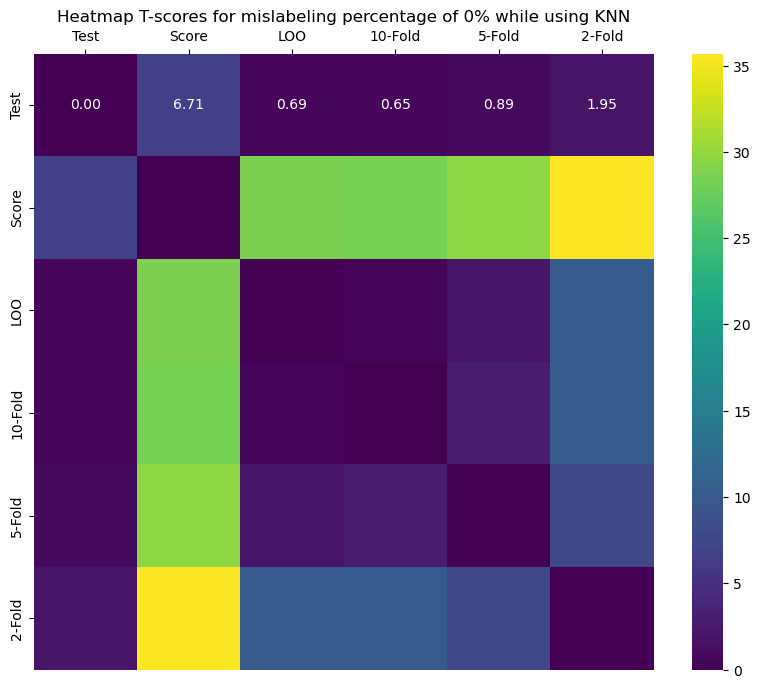

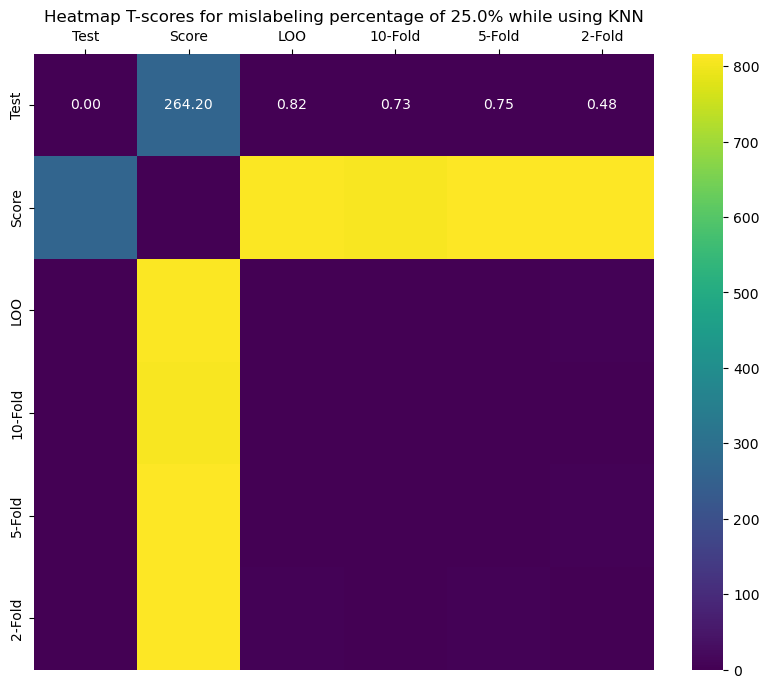

In [ ]:
labels = ["Test", "Score", "LOO", "10-Fold", "5-Fold", "2-Fold"]
mislabeling_percentages = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]

for x, pc in enumerate(mislabeling_percentages):
    if pc in desired_percentages:
      matrix = KNN_tscore_matrix[x]
      plt.figure(figsize=(10, 8))
      plt.title("Heatmap T-scores for mislabeling percentage of {}% while using KNN".format(mislabeling_percentages[x]*100))
      heatmap = sns.heatmap(matrix, annot=True, fmt='.2f', cbar=True, cmap='viridis')
      heatmap.xaxis.set_ticks_position('top')
      plt.xticks(np.arange(len(matrix)) + 0.5, labels)
      plt.yticks(np.arange(len(matrix)) + 0.5, labels)
      plt.show()

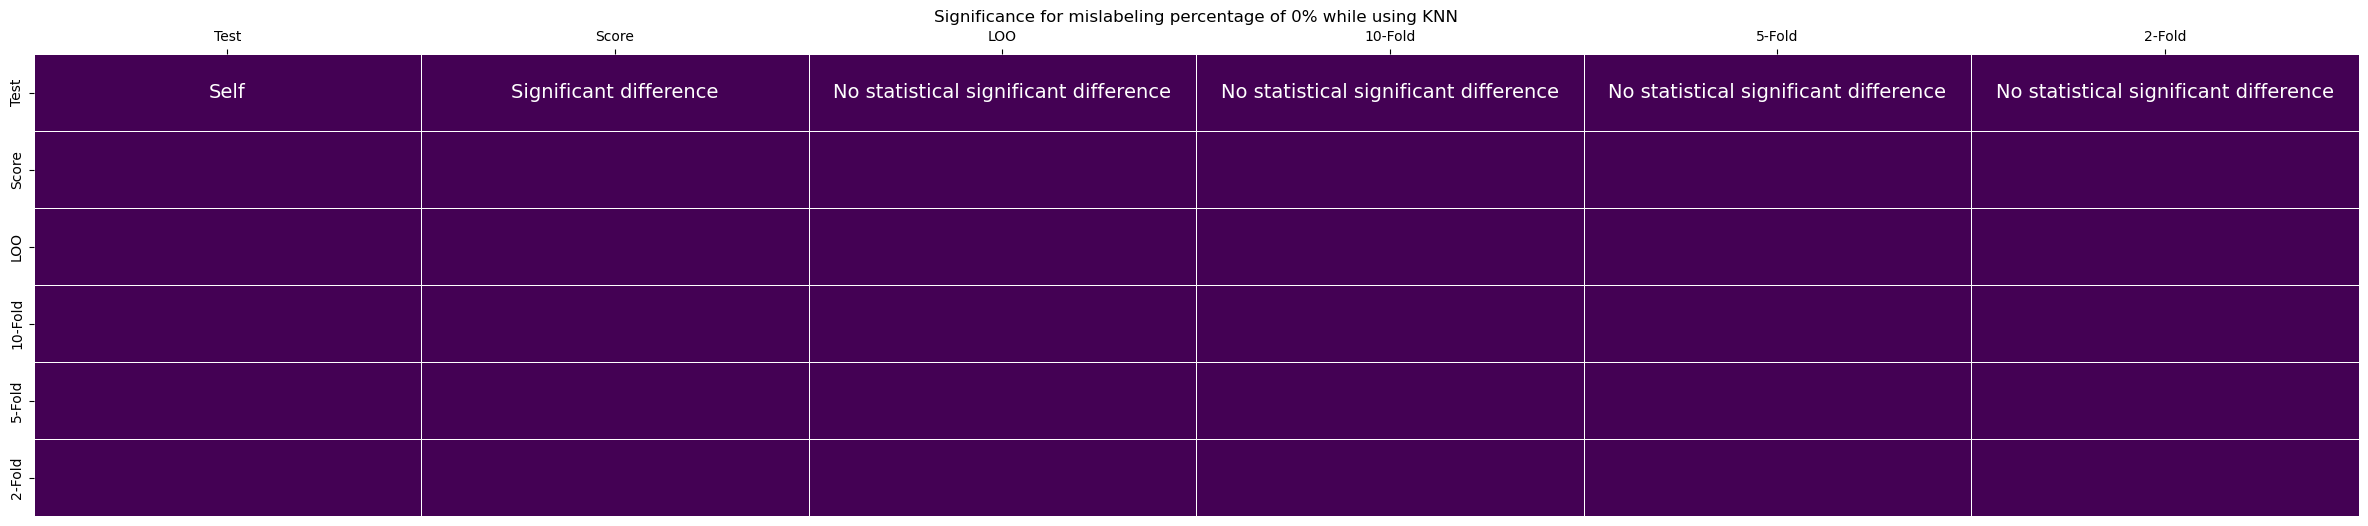

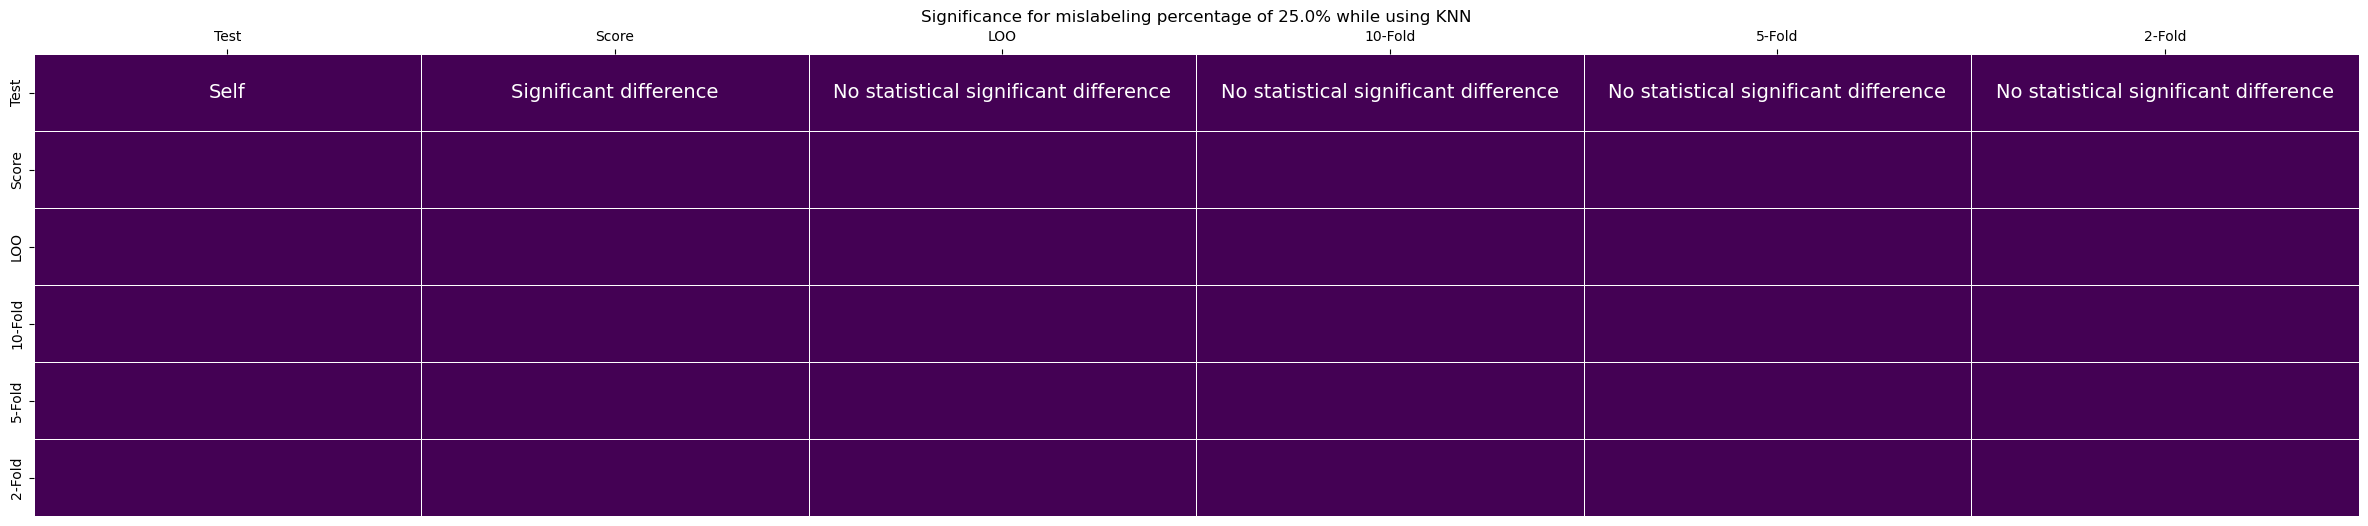

In [ ]:
labels = ["Test", "Score", "LOO", "10-Fold", "5-Fold", "2-Fold"]
mislabeling_percentages = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]

for x, pc in enumerate(mislabeling_percentages):
    if pc in desired_percentages:
      matrix = KNN_significance_matrix[x]
      plt.figure(figsize=(30, 6))
      plt.title("Significance for mislabeling percentage of {}% while using KNN".format(mislabeling_percentages[x]*100))
      heatmap = sns.heatmap(np.zeros_like(matrix, dtype=float), annot=matrix, fmt='', cbar=False, cmap='viridis', annot_kws={"size": 14}, linewidths=.5)
      heatmap.xaxis.set_ticks_position('top')
      plt.xticks(np.arange(len(matrix)) + 0.5, labels)
      plt.yticks(np.arange(len(matrix)) + 0.5, labels)
      plt.show()

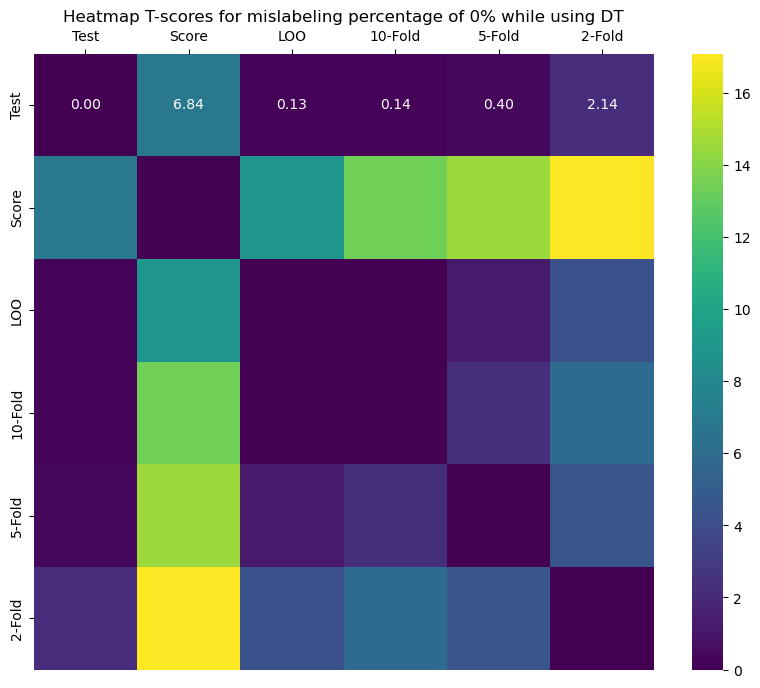

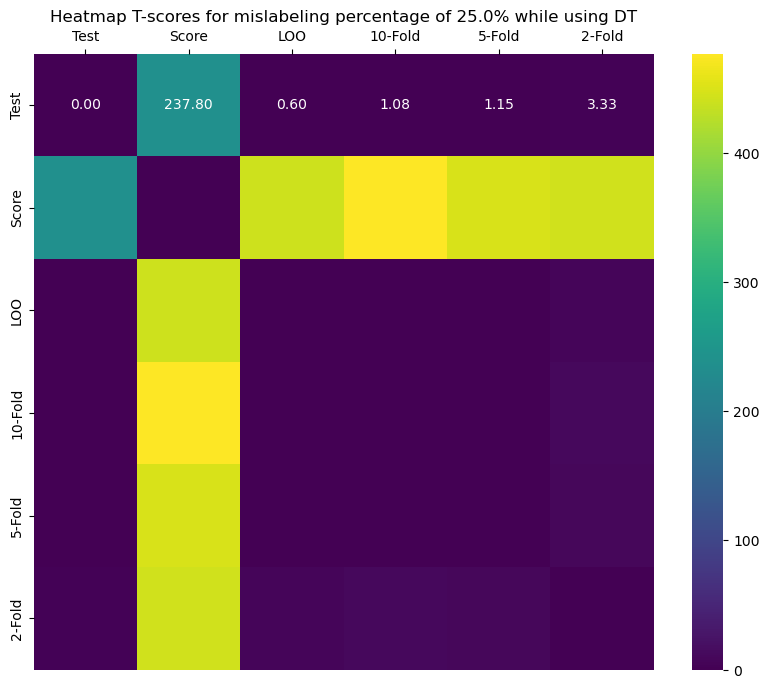

In [ ]:
labels = ["Test", "Score", "LOO", "10-Fold", "5-Fold", "2-Fold"]
mislabeling_percentages = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]

for x, pc in enumerate(mislabeling_percentages):
    if pc in desired_percentages:
      matrix = DT_tscore_matrix[x]
      plt.figure(figsize=(10, 8))
      plt.title("Heatmap T-scores for mislabeling percentage of {}% while using DT".format(mislabeling_percentages[x]*100))
      heatmap = sns.heatmap(matrix, annot=True, fmt='.2f', cbar=True, cmap='viridis')
      heatmap.xaxis.set_ticks_position('top')
      plt.xticks(np.arange(len(matrix)) + 0.5, labels)
      plt.yticks(np.arange(len(matrix)) + 0.5, labels)
      plt.show()

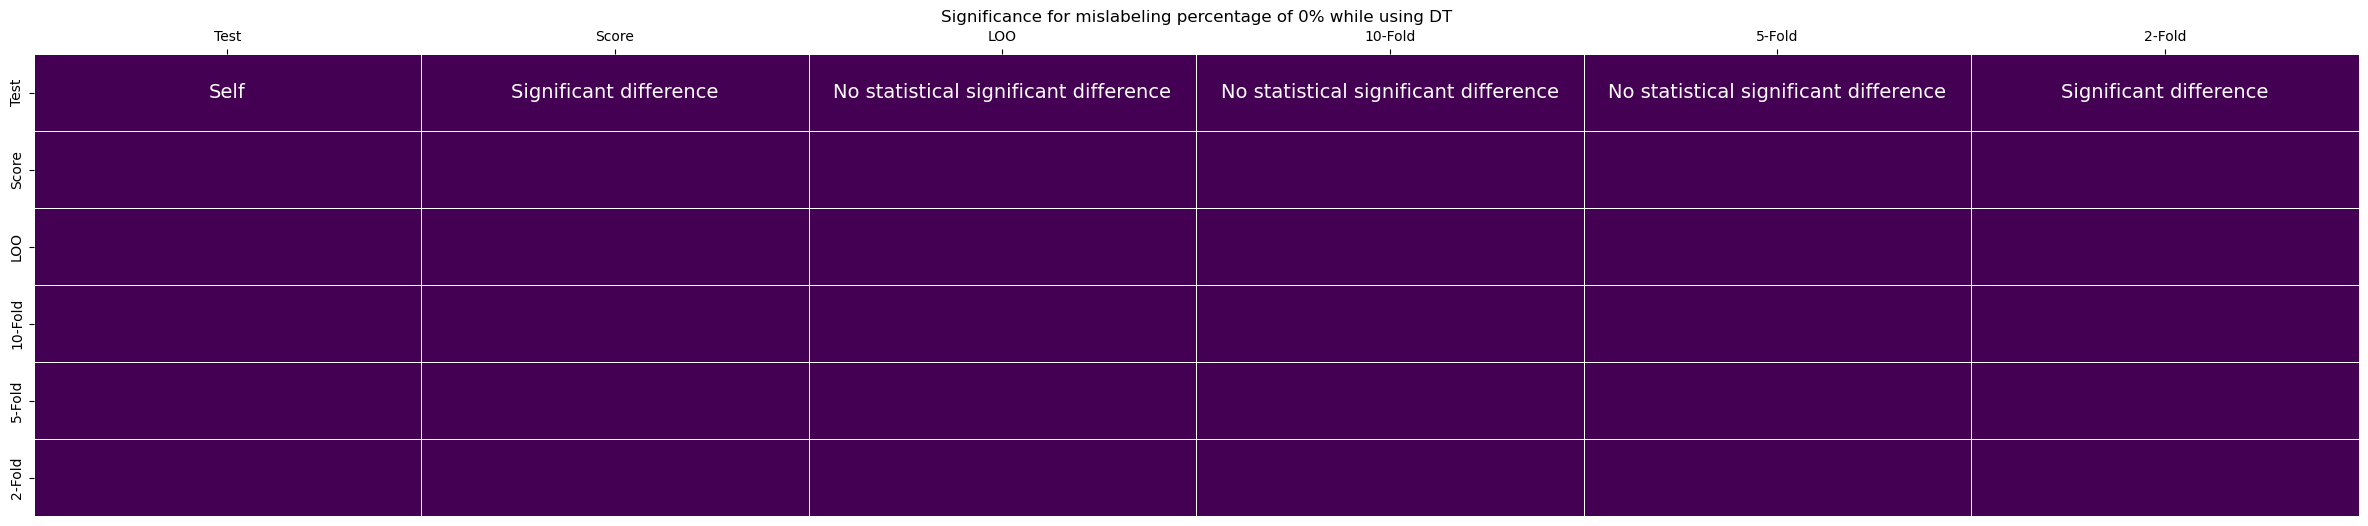

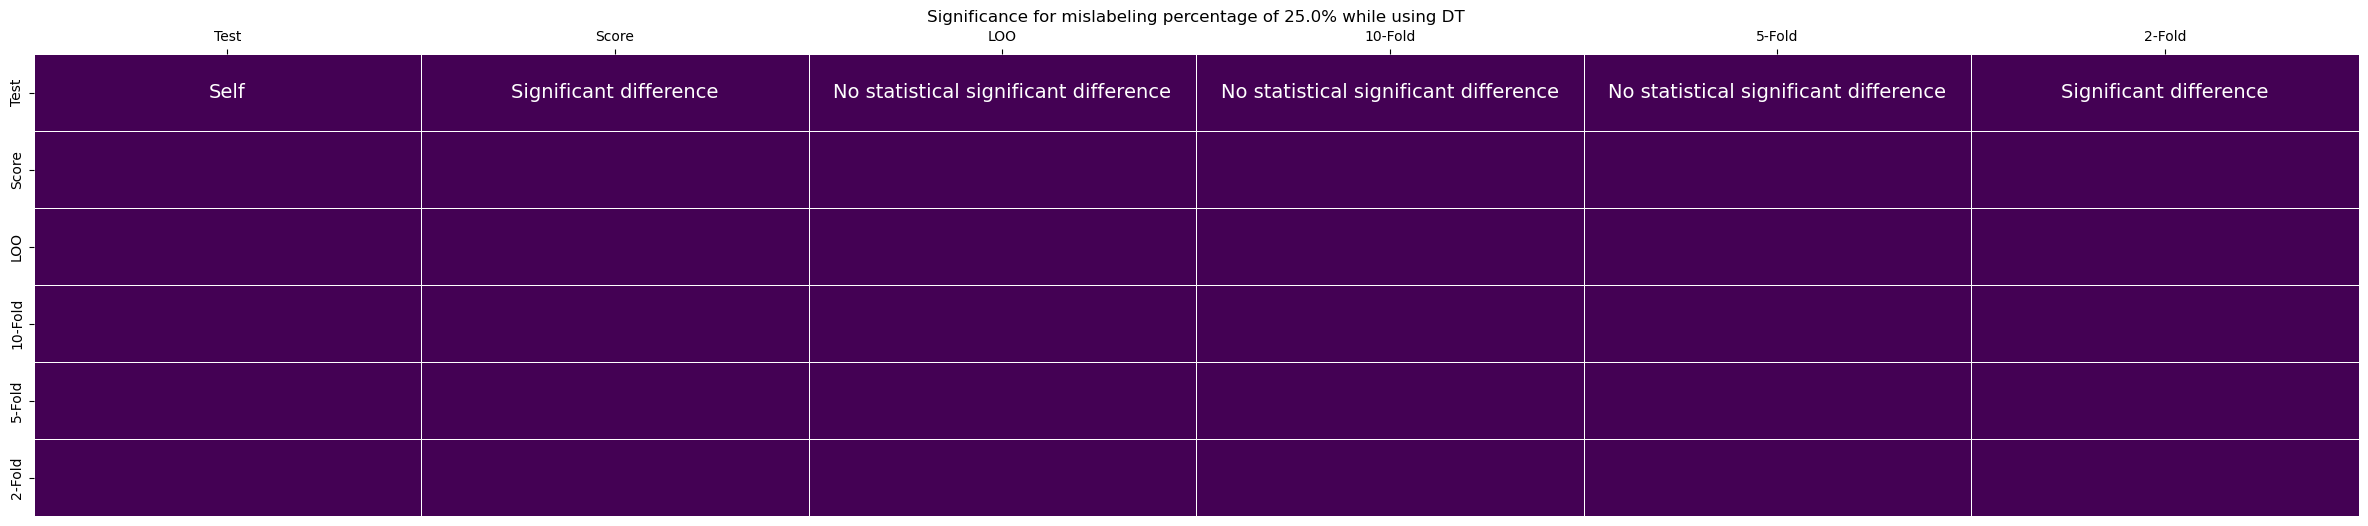

In [ ]:
labels = ["Test", "Score", "LOO", "10-Fold", "5-Fold", "2-Fold"]
mislabeling_percentages = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]

for x, pc in enumerate(mislabeling_percentages):
    if pc in desired_percentages:
      matrix = DT_significance_matrix[x]
      plt.figure(figsize=(30, 6))
      plt.title("Significance for mislabeling percentage of {}% while using DT".format(mislabeling_percentages[x]*100))
      heatmap = sns.heatmap(np.zeros_like(matrix, dtype=float), annot=matrix, fmt='', cbar=False, cmap='viridis', annot_kws={"size": 14}, linewidths=.5)
      heatmap.xaxis.set_ticks_position('top')
      plt.xticks(np.arange(len(matrix)) + 0.5, labels)
      plt.yticks(np.arange(len(matrix)) + 0.5, labels)
      plt.show()

These results show that there is nearly always a significant difference between the accuracy-score returned by determining the _out-of-sample_ accuracy and the other methods.

We can also notice that the _variance_ noticed when using decision trees is large enough to be considered significant at multiple points.

## Evaluation of Hypotheses
1. Mislabeling will only have a **small impact** on cross-validation's ability to accuratly estimate the _out-of-sample_ accuracy.
>  - We can completely disprove this hypothesis as the T-test showed a significant difference between the cross-validation results and the estimated _out-of-sample_ accuracy.
>  - We cannot prove or disprove if this hypothesis only fails for this specific dataset and hyperparameters
>  - We cannot prove or disprove if this hypothesis still fails for a mislabeling percentage greater than 50%
2. The **Leave-One-Out** strategy will no longer be the best strategy to estimate the _out-of-sample_ accuracy.
>  - We cannot prove or disprove this hypothesis for KNN
>  - For KNN Leave-one-out provided nearly the same result as other cross-validation strategies
>  - The hypothesis could possibly be rejected for DT's, as for some mislabeling percentages LOO turned out to be the "best" estimator while having a significant difference compared to the other methods.
3. Decision trees will be more susceptible to _out-of-sample_ drops in accuracy due to training on mislabeled data compared to KNN.
>  - KNN appears to be more robust when the mislabeling percentage is between 0-40%
>  - DT has a much flatter curve when the mislabeling percentage is >=40%, with a much steeper dropoff when approaching 50% mislabeling.



## Limitations
While some statistically significant results were found, we could not help but notice that these might be the result of the specific dataset and hyperparameters used. A different dataset, possibly containing more than 2 classes, combined with different hyperparameters could return vastly different results.



## Future Work
For future research we propose testing on different, more complex datasets. This could either strengthen the claim that mislabeled dataset causes a laps in cross-validation performance, or alter the claim that this laps only occurs in specific scenario's. Another interesting path could possibly be forcibly inducing overfitting and observing how this might influence the results.

# <span style='color:blue'>Research Question #2</span>

## Overview

For this section, we will use _Random Forest Regression_ & _XGBoost Regression_ with a real-world, diamond price regression dataset:

The **research question** we seek to answer is:


_<center><span style='color:green'>How susceptible are the different models to the phenomenon of overfitting and how do the model hyperparameters influence it?_</span></center>

## Definition of Overfitting
Overfitting in the context of machine learning refers to a phenomenon where a model learns to perform exceptionally well on the training data but fails to generalize effectively to unseen or new data. It occurs when a model captures noise or random fluctuations in the training data as if they were meaningful patterns. Overfitting is a critical challenge in machine learning as it can lead to poor performance and unreliable predictions in real-world applications.
Numerically, we can measure it by comparing the in-sample and out-of-sample error rates (e.g. the performance on the train VS. test dataset). 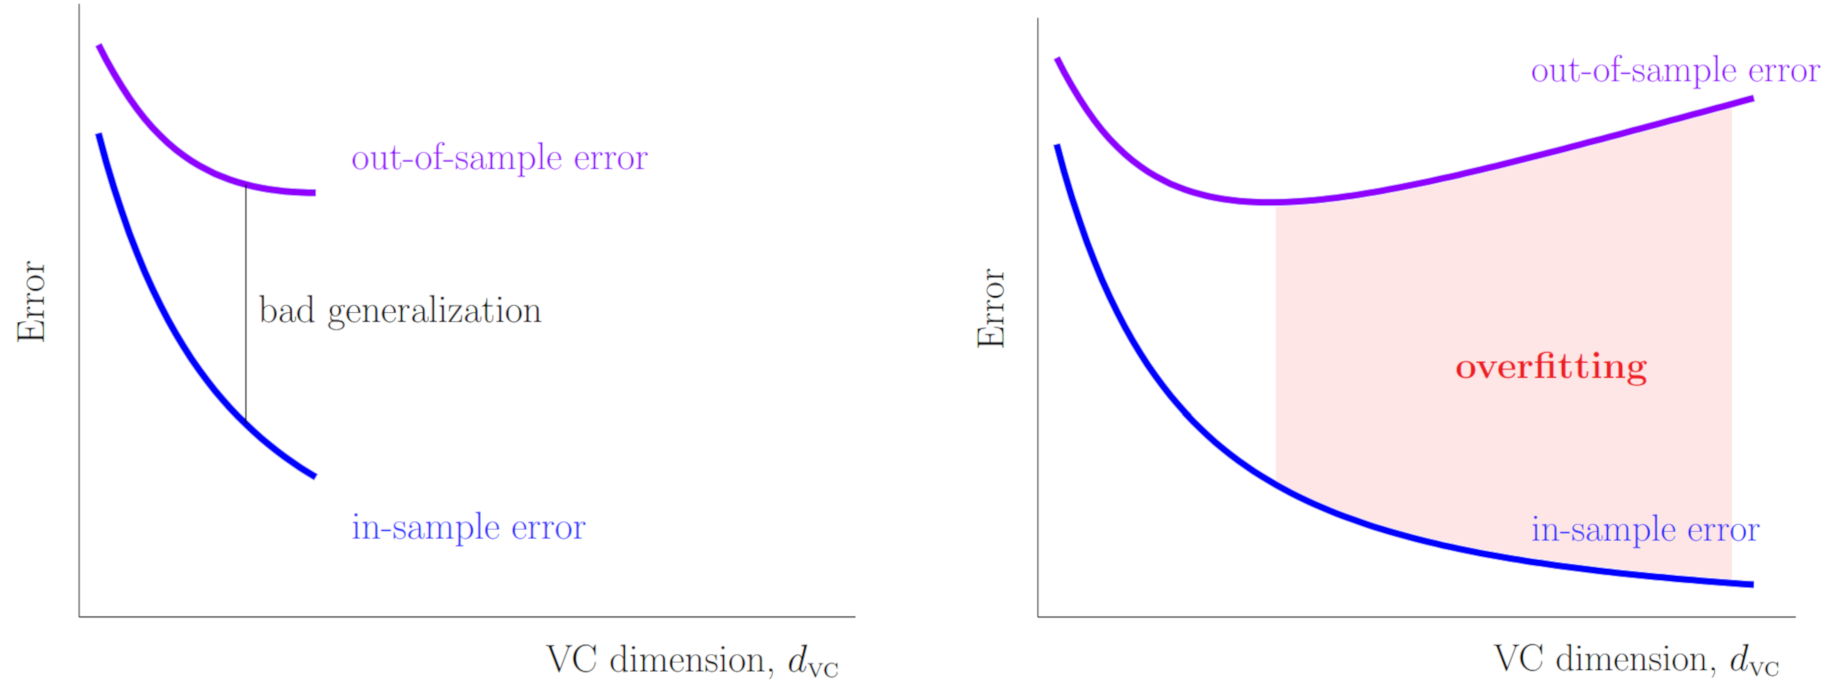
Image Source: [Malik Magdon-Ismail](https://www.cs.rpi.edu/~magdon/courses/LFD-Slides/SlidesLect11.pdf)

However, it is not enough to measure the difference between the in-sample and out-of-sample error, as this alone just indicates a bad generalization of the model. In order for this gap to become overfitting, the out-of-sample error also has to increase, while the in-sample error further decreases, as can be seen in the figure above.
For our following experiments, we do measure the gap between in-sample and out-of-sample error, but we only consider it overfitting if the out-of-sample error increases.


## Hyperparameter Selection
Since our research question is linked to the overfitting of models, we want to investigate parameters which have a direct influence on the complexity and therefore overfitting potential.

We choose two parameters which are present in both Random Forests and XGBoost which hence makes them directly comparable.

1. _n\_estimators_: The amount of trees used in the model.
2. _max\_depth_: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
3. _min\_samples\_leaf_ (Random Forest) VS. _min\_child\_weight_ (XGBoost)
>  - _min\_samples\_leaf_: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
>  - _min\_child\_weight_: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be. For regression problems with MSE loss, the sum of instance weight will result in the _min\_samples\_leaf_ because the second derivative of MSE loss equals one.
> - Therefore, if we have a regression problem with MSE loss, we can use the two parameters interchangeably.
> - Both parameters act as regularizers, reducing the risk of overfitting by preventing the creation of nodes that are too small and unreliable.

  Please also refer to the documentation of [RandomForestRegressors](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html) for more information, as well as to our **Appendix** section for general descriptions of those ml models.

## Strategy

To answer this research question, we will take the following steps for parameter that we are researching:

```
1. Fix all parameters except the one in question.
2. Choose a range in which the parameter in question is researched.
3. Repeat 30 times (with different seeds) for each model type (Random Forest & XGBoost):
    - Train model, and record its in-sample & out-of-sample error for each parameter in the range
4. Calculate averages between seeds
5. Analyze results to determine the impact of model type & parameter configurations on the in-sample & out-of-sample error
```

To estimate out-of-sample error, we will score the performance of our models on test data that has not been used for training. The train/test split is 80/20%.  Furthermore, for each of the 30 benchmark executions, we will create a different train/test split. (this might seem strange at first, but we are essentially treating each execution as being in a parallel universe wherein a different set of training samples are available to us from the *full* distribution of all possible samples.

### Hypotheses

Ultimately, we hypothesize the following:
1. XGBoost will have slightly lower out-of-sample errors since it is generally considered to be a more powerful model.
2. For both model types, models will have _lower_ in-sample errors if their complexity goes up, e.g. if _n\_estimators_ and _max\_depth_ go up.
3. For both model types, models will show _more_ overfitting, if their complexity goes up, e.g. if _n\_estimators_ and _max\_depth_ go up.
4. For both model types, models will show _less_ overfitting, if their regularization increases, e.g. if _min\_samples\_leaf_ and _min\_child\_weight_ go up.
5. Random Forests will show _less_ overfitting, since it is a less complex model.

## Setup


### Imports

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

## Dataset
For this research question, we use a [diamond prices dataset from Kaggle](https://www.kaggle.com/datasets/vittoriogiatti/diamondprices). It has nine features:
- **carat**: float; One carat equals 0.200 grams.
- **cut**: categorical (Ideal, Premium, Very Good, Good, Fair)
- **color**: categorical (D, E, F, G, H, I, J) (D is best, J is worst)
- **clarity**: categorical (IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1) (IF is best, I1, is worst)
- **depth**: float; Defines the cut shape. Ideally, a stone cut is around 60% of it diameter
- **table**: float; Defines the cut shape
- **price**: float
- **x**: float
- **y**: float
  - x and y are the radiuses of the diameter, the closer they are, the more the diameter is a perfect circle.
- **z**: float; $z = x * depth$

The target variable is **price**. Since it is a float value, we try to predict it in a regression task.

In [ ]:
# If downloading the diamonds dataset CSV file from github doesn't work, it can also
# be downloaded from Kaggle: https://www.kaggle.com/datasets/vittoriogiatti/diamondprices,
# and then loaded using the commented-out line of code below.
# df = pd.read_csv("DiamondsPrices.csv")

# Load diamonds dataset from GitHub
url = "https://raw.githubusercontent.com/seanscofield/sfml-project/main/data/DiamondsPrices.csv"

diamonds_df = pd.read_csv(
    url,
    sep=',',
    encoding='utf-8',
)

### Exploratory Data Analysis (EDA)

In [ ]:
diamonds_df.head(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


In [ ]:
diamonds_df.shape

(53940, 10)

In [ ]:
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Feature Distributions

/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

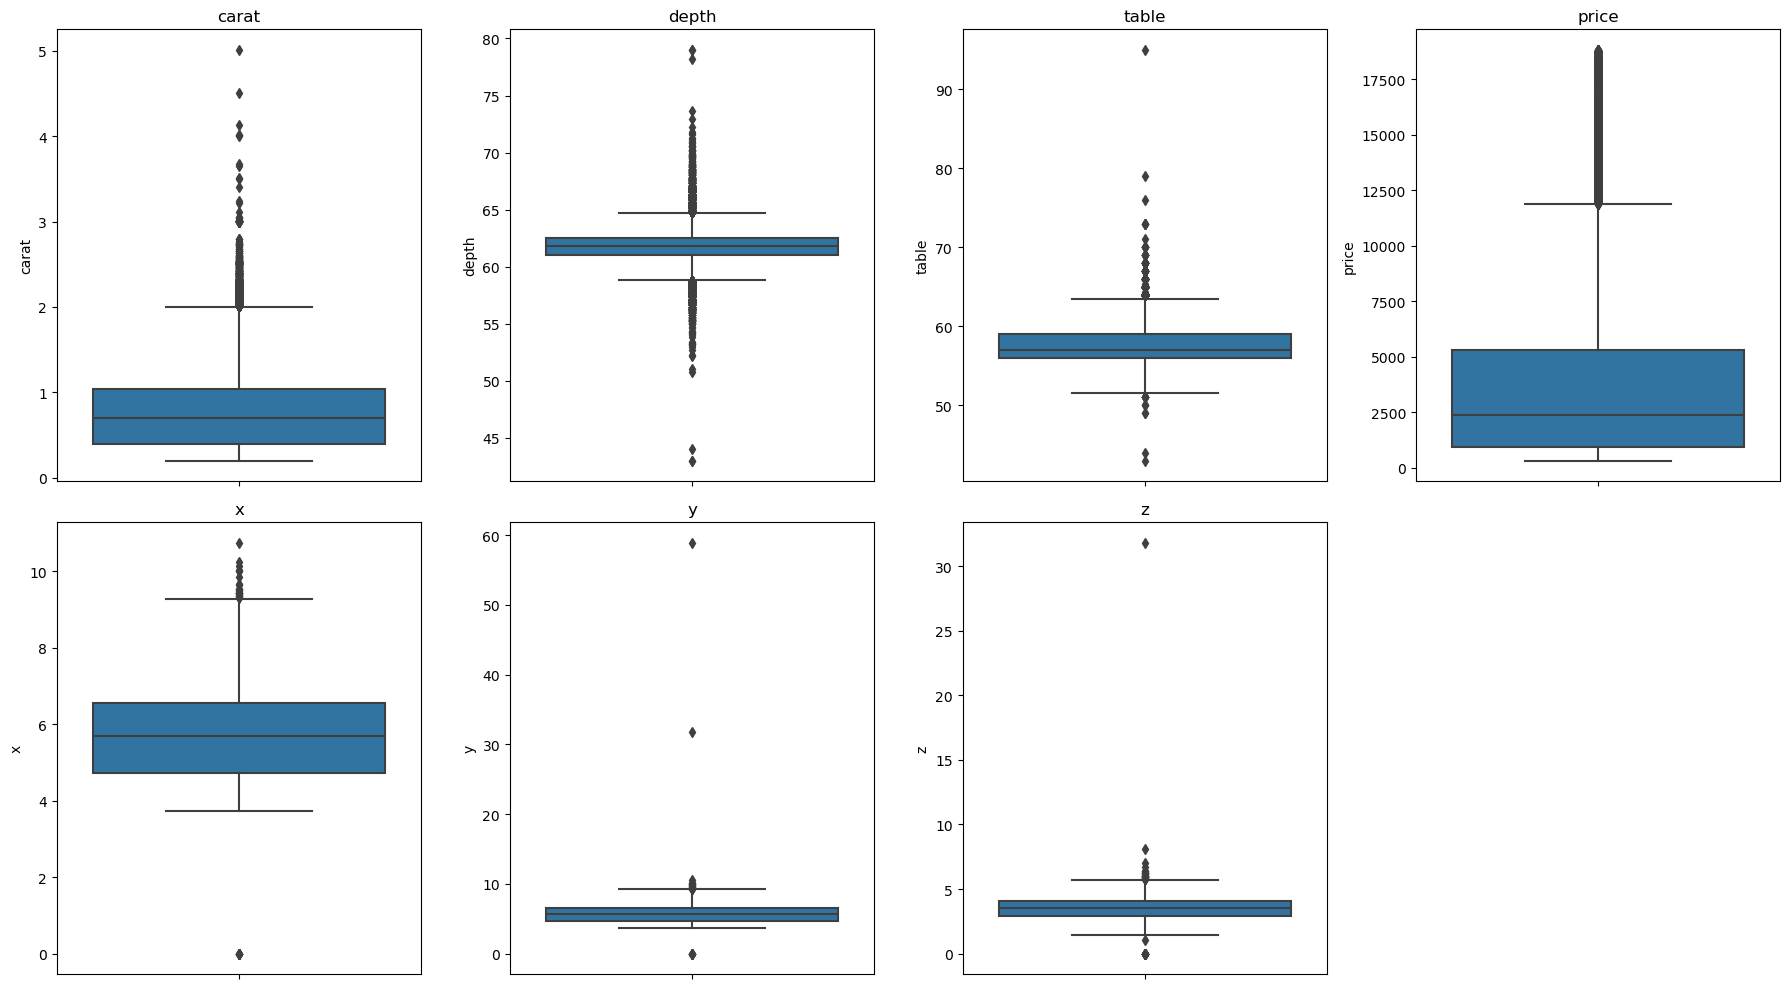

In [ ]:
numerical_columns = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
categorical_columns = ['cut', 'color', 'clarity']

# Create a figure with the desired size
plt.figure(figsize=(18, 10))

# Loop through the numerical columns and create a boxplot for each
for i, column in enumerate(numerical_columns):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(data=diamonds_df, y=column)
    plt.title(column)

# Adjust layout
plt.tight_layout()
plt.show()

/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

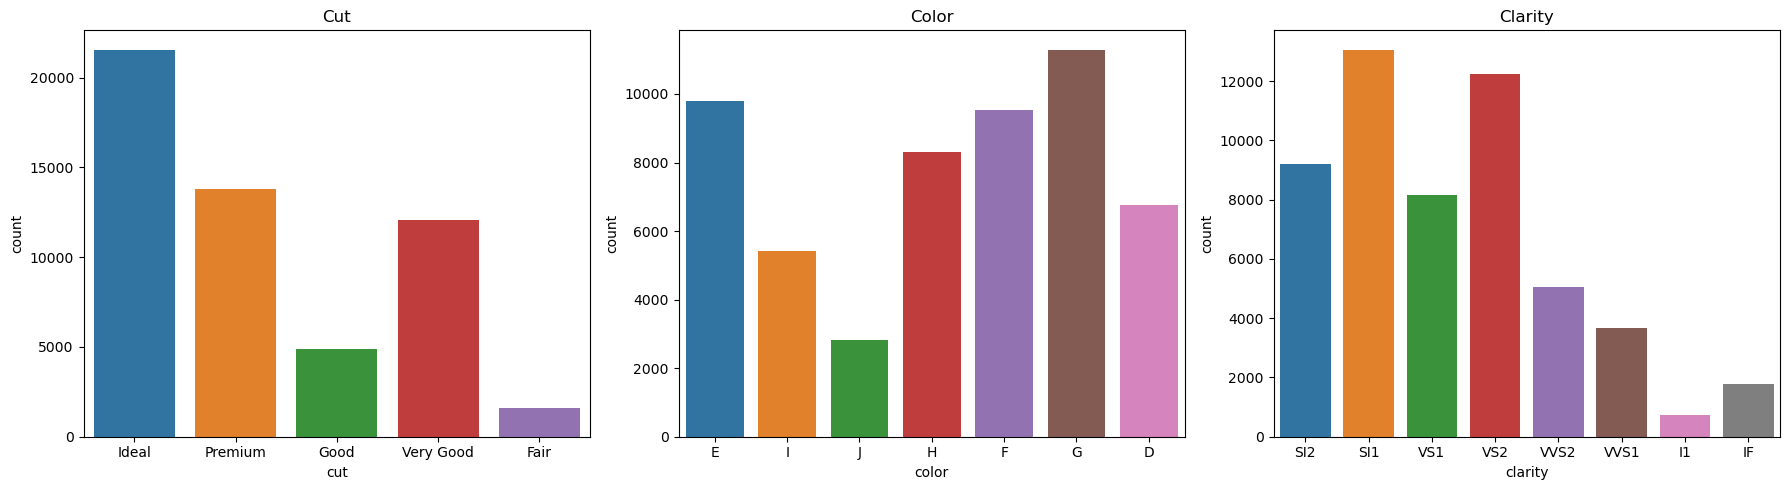

In [ ]:
plt.figure(figsize=(18, 5))

# First subplot for 'cut'
plt.subplot(1, 3, 1)
sns.countplot(data=diamonds_df, x='cut')
plt.title('Cut')

plt.subplot(1, 3, 2)
sns.countplot(data=diamonds_df, x='color')
plt.title('Color')

plt.subplot(1, 3, 3)
sns.countplot(data=diamonds_df, x='clarity')
plt.title('Clarity')

plt.tight_layout()
plt.show()

### Data Preprocessing

In [ ]:
diamonds_df.isnull().sum() # check whether there are null values in the dataset

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [ ]:
df = diamonds_df

#### Encoding of catergorical features

In [ ]:
# Since we have a clear order of quality in this category, we assign the numerical values manually in the right order.
cut_mapping = {
    'Ideal': 5,
    'Premium': 4,
    'Very Good': 3,
    'Good': 2,
    'Fair': 1
}

df['cut'] = df['cut'].map(cut_mapping)

In [ ]:
# Since we have a clear order of quality in this category, we assign the numerical values manually in the right order.
clarity_mapping = {
    'IF': 8,
    'VVS1': 7,
    'VVS2': 6,
    'VS1': 5,
    'VS2': 4,
    'SI1': 3,
    'SI2': 2,
    'I1': 1,
}
df['clarity'] = df['clarity'].map(clarity_mapping)

In [ ]:
# Since we have a clear order of quality in this category, we assign the numerical values manually in the right order.
color_mapping = {
    'D': 7,
    'E': 6,
    'F': 5,
    'G': 4,
    'H': 3,
    'I': 2,
    'J': 1,
}
df['color'] = df['color'].map(color_mapping)

In [ ]:
df.head(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,6,5,56.9,65.0,327,4.05,4.07,2.31


#### Pair-wise feature correlations

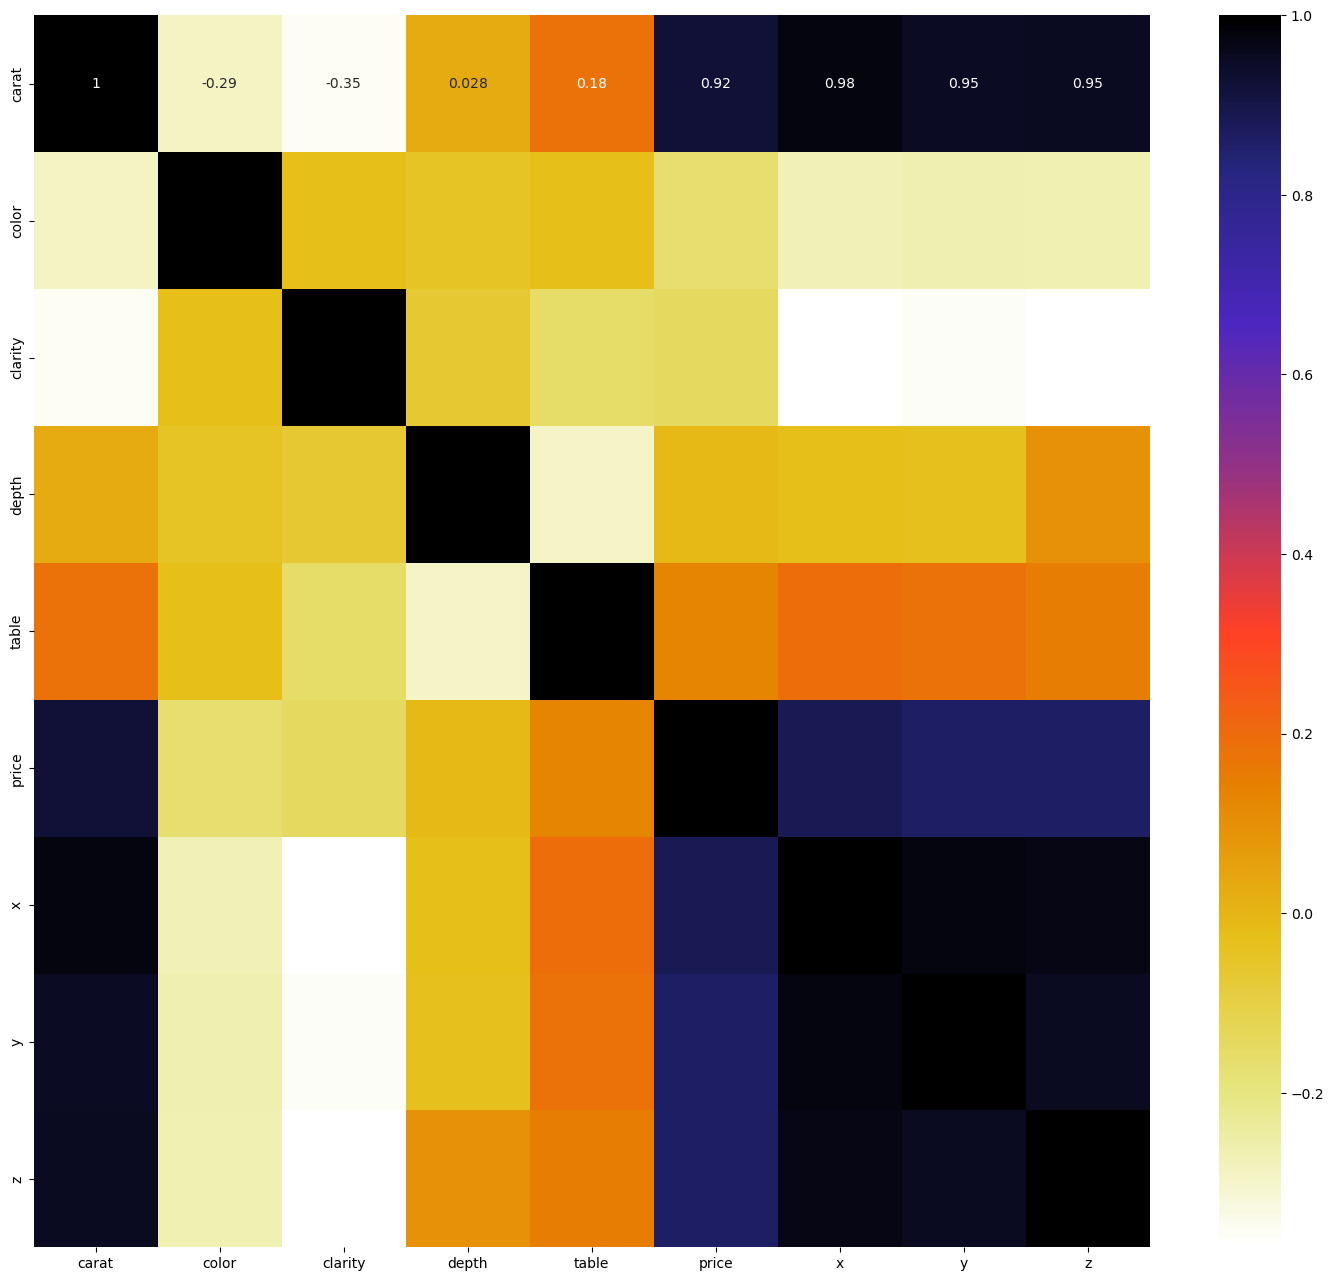

In [ ]:
numeric_df = diamonds_df.select_dtypes(include=[float, int]) # Select only numeric columns
plt.figure(figsize=(18, 16))
sns.heatmap(numeric_df.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

We observe that price is highly correlated to carat, x, y and z. Apparently, the weight and therefore amount of material seems to be very important for the price. This also explains that the dimensions x,y and z are important, since they contribute to the weight of the diamond. The other variables color, clarity and table also show reasonable correlations to the target, making this dataset feasable to learn on.
However, cut and depth show a very weak correlation, prompting us to remove these features from the dataset to reduce complexity.

#### Feature Selection and Split


In [ ]:
X = df.drop(columns=['price', "cut", "depth"], axis=True) # Remove target variable and the two uninformative features cut and depth
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape},")

X_train: (43152, 7), y_train: (43152,), X_test: (10788, 7), y_test: (10788,),


### Helper Functions

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, print_result=True):
    # Predict on Train
    pred_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    r2_train = r2_score(y_train, pred_train)
    if print_result:
      print(f"{model.__class__.__name__} Train Result\nRMSE: {rmse_train}, R2-Score: {r2_train}")

    # Predict on Test
    pred_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r2_test = r2_score(y_test, pred_test)
    if print_result:
      print(f"{model.__class__.__name__} Test Result\nRMSE: {rmse_test}, R2-Score: {r2_test}")
    return rmse_train, r2_train, rmse_test, r2_test

In [ ]:
def initialize_arrays(n):
    rf_rmse_train = [[] for _ in range(n)]
    rf_r2_train = [[] for _ in range(n)]
    rf_rmse_test = [[] for _ in range(n)]
    rf_r2_test = [[] for _ in range(n)]
    xgb_rmse_train = [[] for _ in range(n)]
    xgb_r2_train = [[] for _ in range(n)]
    xgb_rmse_test = [[] for _ in range(n)]
    xgb_r2_test = [[] for _ in range(n)]
    return rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test

In [ ]:
def add_values(i, array1, value1, array2, value2, array3, value3, array4, value4):
  array1[i].append(value1)
  array2[i].append(value2)
  array3[i].append(value3)
  array4[i].append(value4)
  return array1, array2, array3, array4

In [ ]:
def compute_average(rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test, n):
  arrays = [rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test]
  arrays = [[sum(x)/len(x) for x in arr] for arr in arrays]
  return arrays

In [ ]:
def plot_results(rf_train, rf_test, xgb_train, xgb_test, x_axis, x_label, y_label):
    plt.figure(figsize=(14, 8))

    # Plot RMSE for Random Forest
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, rf_train, label=f'RF {y_label} Train', marker='o', color='blue')
    plt.plot(x_axis, rf_test, label=f'RF {y_label} Test', marker='x', color='blue')

    rf_in_out_difference = [test - train for train, test in zip(rf_train, rf_test)]
    plt.plot(x_axis, rf_in_out_difference, label='RF In-Out Difference', color='blue', linestyle='dotted')

    min_rf_test_value = min(rf_test)
    plt.axvline(x_axis[rf_test.index(min_rf_test_value)], color='black', linestyle='--', label='Min RF Test Value')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{y_label} for Random Forest')
    plt.legend()
    plt.grid(True)

    # Plot RMSE for XGBoost
    plt.subplot(2, 1, 2)
    plt.plot(x_axis, xgb_train, label=f'XGB {y_label} Train', marker='o', color='red')
    plt.plot(x_axis, xgb_test, label=f'XGB {y_label} Test', marker='x', color='red')

    xgb_in_out_difference = [test - train for train, test in zip(xgb_train, xgb_test)]
    plt.plot(x_axis, xgb_in_out_difference, label='XGB In-Out Difference', color='red', linestyle='dotted')

    min_xgb_test_value = min(xgb_test)
    plt.axvline(x_axis[xgb_test.index(min_xgb_test_value)], color='black', linestyle='--', label='Min XGB Test Value')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{y_label} for XGBoost')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_significance(rf_train, rf_test, xgb_train, xgb_test, parameter_range, x_label, y_label):
    t_statistics_train = []
    p_values_train = []
    t_statistics_test = []
    p_values_test = []

    # Perform t-tests for train metric
    for rf, xgb in zip(rf_train, xgb_train):
        t_stat, p_val = stats.ttest_ind(rf, xgb)
        t_statistics_train.append(t_stat)
        p_values_train.append(p_val)

    # Perform t-tests for test metric
    for rf, xgb in zip(rf_test, xgb_test):
        t_stat, p_val = stats.ttest_ind(rf, xgb)
        t_statistics_test.append(t_stat)
        p_values_test.append(p_val)

    # Plotting
    labels = [f'{i}' for i in parameter_range]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for train metric
    color = 'tab:green'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('t-statistic', color=color)
    ax1.bar(labels, t_statistics_train, color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(f'Comparisons of Train {y_label}')

    ax3 = ax1.twinx()
    color = 'tab:orange'
    ax3.set_ylabel('p-value', color=color)
    ax3.plot(labels, p_values_train, color=color, marker='o')
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.axhline(y=0.05, color='tab:orange', linestyle='--', alpha=0.7)
    ax3.set_ylim(-0.02, 1)

    # Plot for test metric
    color = 'tab:green'
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('t-statistic', color=color)
    ax2.bar(labels, t_statistics_test, color=color, alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_title(f'Comparisons of Test {y_label}')

    ax4 = ax2.twinx()
    color = 'tab:orange'
    ax4.set_ylabel('p-value', color=color)
    ax4.plot(labels, p_values_test, color=color, marker='o')
    ax4.tick_params(axis='y', labelcolor=color)
    ax4.axhline(y=0.05, color='tab:orange', linestyle='--', alpha=0.7)
    ax4.set_ylim(-0.02, 1)

    fig.tight_layout()
    plt.suptitle('T-Test Results: RF vs XGB', y=1.02)
    plt.show()

### Baselines

#### Linear Regression


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
_, _, _, _ = evaluate_model(lin_model, X_train, y_train, X_test, y_test)

LinearRegression Train Result
RMSE: 1227.566090011742, R2-Score: 0.9053427616130669
LinearRegression Test Result
RMSE: 1233.908856960775, R2-Score: 0.90422418267989


#### Random Forest (RF)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
_, _, _, _ = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

RandomForestRegressor Train Result
RMSE: 207.26926688359538, R2-Score: 0.9973014287680628
RandomForestRegressor Test Result
RMSE: 546.0449136715183, R2-Score: 0.9812437317321124


#### XGBoost (XGB)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
_, _, _, _ = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int o

XGBRegressor Train Result
RMSE: 391.72089061321185, R2-Score: 0.9903613207094355
XGBRegressor Test Result
RMSE: 547.344953544777, R2-Score: 0.9811543144590583


/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/seanscofield/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int o

Looking at the baseline experiments, we can see that the different models perform, well with Linear Regression achieving over 90% R2 and RF and XGB even reaching over 98%.

## Performing our experiment

### Experiment 1: Variation of n_estimators
For this experiment, we research how the amount of trees can influence the overfitting of models. We fix `max_depth=None` and `min_samples_leaf=1` or `min_child_weight=1` to be the default settings and change the `n_estimators` parameter iteratively for both RF and XGB.

In [ ]:
def run_n_estimators_experiment(amount_of_iterations, parameter_range, max_depth, regularization):
  rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = initialize_arrays(len(parameter_range))

  for seed in range(0, amount_of_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    count = 0
    for i in parameter_range:
      # Fit Random Forest - Using different n_estimators
      rf_model = RandomForestRegressor(n_estimators=i, max_depth=max_depth, min_samples_leaf=regularization, random_state=seed)
      rf_model.fit(X_train, y_train)
      rmse_train, r2_train, rmse_test, r2_test = evaluate_model(rf_model, X_train, y_train, X_test, y_test, print_result=False)
      rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test = add_values(count, rf_rmse_train, rmse_train, rf_r2_train, r2_train, rf_rmse_test, rmse_test, rf_r2_test, r2_test)

      # Fit XGBoost - Using different n_estimators
      xgb_model = XGBRegressor(n_estimators=i, max_depth=max_depth, min_child_weight=regularization, random_state=seed)
      xgb_model.fit(X_train, y_train)
      rmse_train, r2_train, rmse_test, r2_test = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, print_result=False)
      xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = add_values(count, xgb_rmse_train, rmse_train, xgb_r2_train, r2_train, xgb_rmse_test, rmse_test, xgb_r2_test, r2_test)
      count += 1

  return rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test

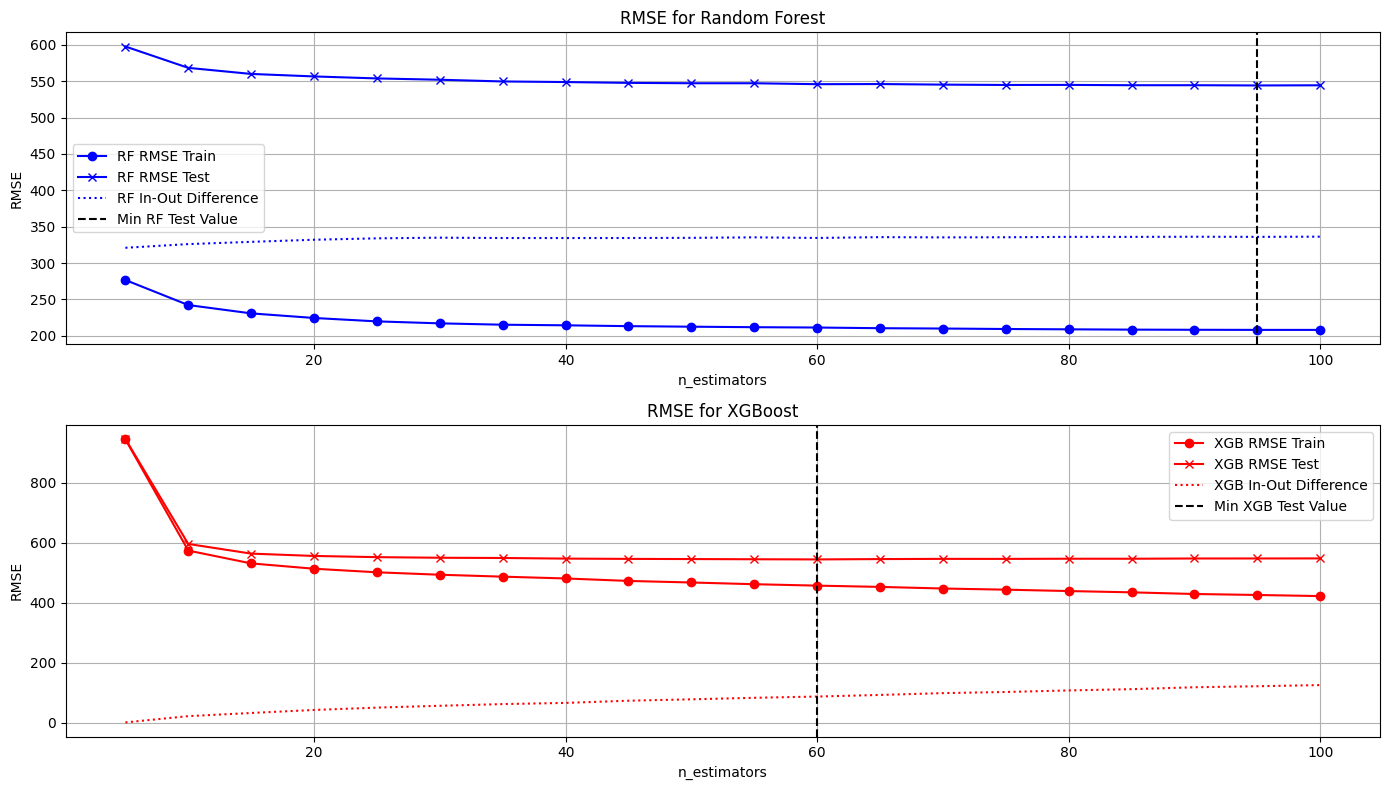

In [ ]:
amount_of_iterations = 30
parameter_range = range(5, 105, 5)
max_depth = None
regularization = 1

rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = run_n_estimators_experiment(amount_of_iterations, parameter_range, max_depth, regularization)
avg_rf_rmse_train, _, avg_rf_rmse_test, _, avg_xgb_rmse_train, _, avg_xgb_rmse_test, _ = compute_average(rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test, amount_of_iterations)

plot_results(avg_rf_rmse_train, avg_rf_rmse_test, avg_xgb_rmse_train, avg_xgb_rmse_test, parameter_range, x_label="n_estimators", y_label="RMSE")

For RF, we can see a constant large gap between in-sample and out-of-sample errors. This might be due to the fact that `max_depth=None` by default. However, we can also observe that both train and test RMSE decrease with a similar rate according to `n_estimators`. This indicates, that while the generalization is quite bad, the model is not overfitting. This is further confirmed by the fact that the minimum test RMSE is at the highest `n_estimators=100` value.

For XBF, we initially have a very small gap between test and train RMSE, which starts opening up further with higher values of `n_estimators`. The test RMSE starts increasing after `n_estimators=60`, but the visual increase is close to zero. We conclude, that the model's generalization capability goes down with higher `n_estimators`, but we do not see any explicit overfitting.

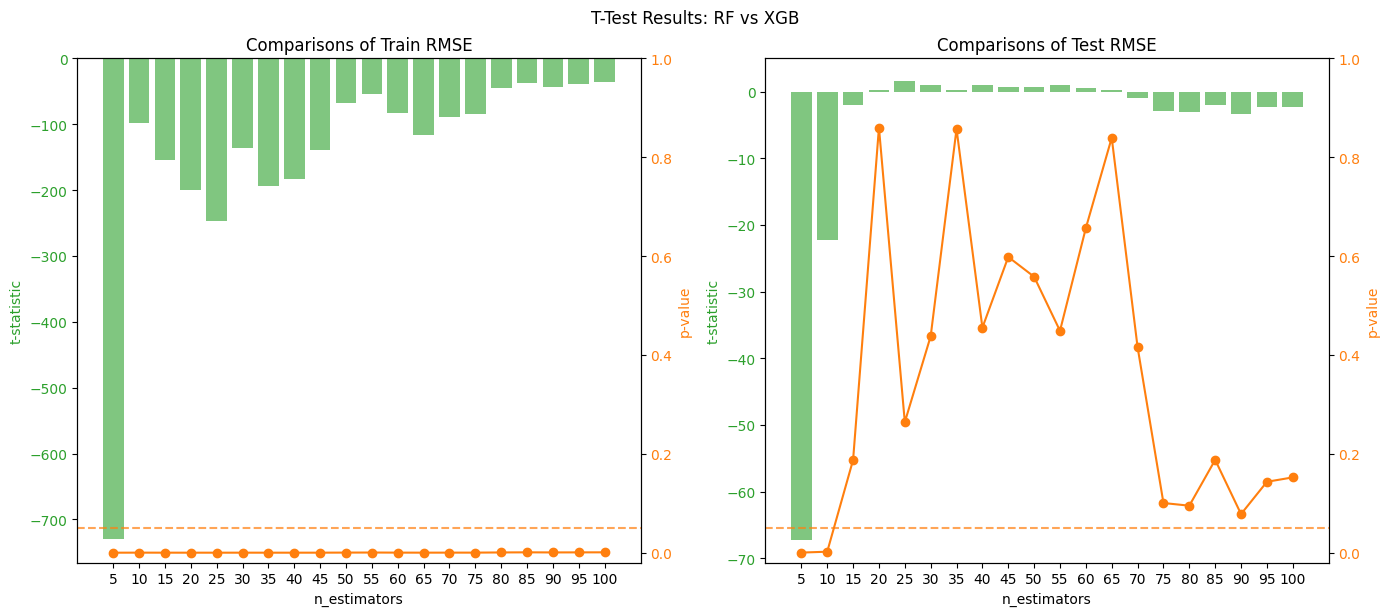

In [ ]:
plot_significance(rf_rmse_train, rf_rmse_test, xgb_rmse_train, xgb_rmse_test, parameter_range, x_label="n_estimators", y_label="RMSE")

As can be seen in the plots above, the train RMSE between RF and XGB are constantly significantly different, indicated by the p-value being near 0. This confirms that RF has a significantly lower in-sample error than XGB.

On the other hand, the test RMSE of the RF is only significantly lower up until `n_estimators=10`. Beyond that point, there is no significant difference in out-of-sample errors between RF and XGB.


### Experiment 2: Variation of max_depth
For this experiment, we research how the deepness of trees can influence the overfitting of models. We fix `n_estimators=50` and `min_samples_leaf=1` and change the `max_depth` parameter iteratively for both RF and XGB.

In [ ]:
def run_max_depth_experiment(amount_of_iterations, parameter_range, n_estimators, regularization):
  rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = initialize_arrays(len(parameter_range))

  for seed in range(0, amount_of_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    count = 0
    for i in parameter_range:
      # Fit Random Forest - Using different max_depth
      rf_model = RandomForestRegressor(n_estimators=50, max_depth=i, min_samples_leaf=1, random_state=seed)
      rf_model.fit(X_train, y_train)
      rmse_train, r2_train, rmse_test, r2_test = evaluate_model(rf_model, X_train, y_train, X_test, y_test, print_result=False)
      rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test = add_values(count, rf_rmse_train, rmse_train, rf_r2_train, r2_train, rf_rmse_test, rmse_test, rf_r2_test, r2_test)

      # Fit XGBoost - Using different max_depth
      xgb_model = XGBRegressor(n_estimators=50, max_depth=i, min_child_weight=1, random_state=seed)
      xgb_model.fit(X_train, y_train)
      rmse_train, r2_train, rmse_test, r2_test = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, print_result=False)
      xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = add_values(count, xgb_rmse_train, rmse_train, xgb_r2_train, r2_train, xgb_rmse_test, rmse_test, xgb_r2_test, r2_test)
      count += 1

  return rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test

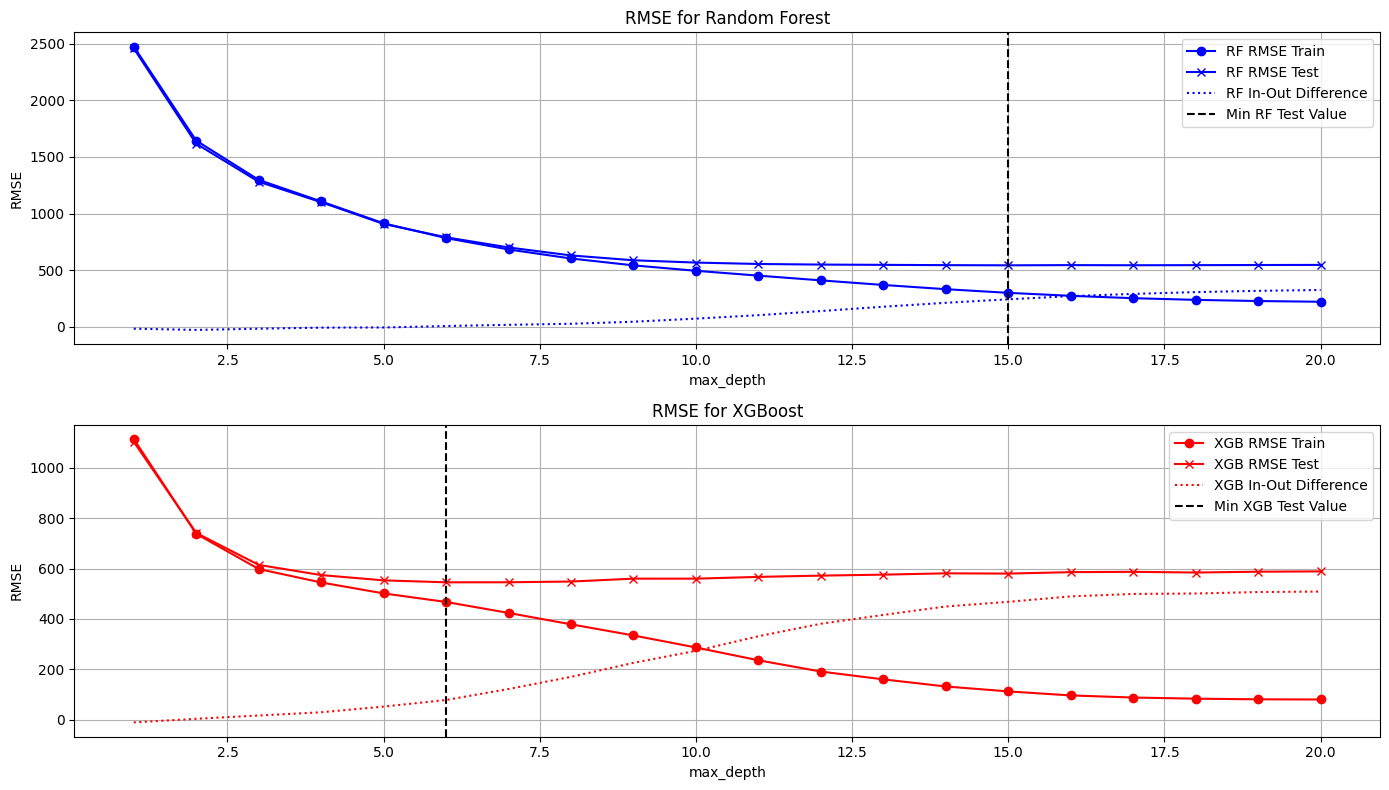

In [ ]:
amount_of_iterations = 30
parameter_range = range(1, 21)
n_estimators = 50
regularization = 1

rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = run_max_depth_experiment(amount_of_iterations, parameter_range, n_estimators, regularization)
avg_rf_rmse_train, _, avg_rf_rmse_test, _, avg_xgb_rmse_train, _, avg_xgb_rmse_test, _ = compute_average(rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test, amount_of_iterations)
plot_results(avg_rf_rmse_train, avg_rf_rmse_test, avg_xgb_rmse_train, avg_xgb_rmse_test, parameter_range, x_label="max_depth", y_label="RMSE")

For RF, we do not see a big gap between in-sample and out-of-sample errors until around `max_depth=10`. After this, a gap opens up. Even though the minimum test RMSE is at `max_depth=14`, visually, no significant increase in RMSE can be detected for even higher values. This indicates that the generalization decreases, but overfitting is not fully achieved for RF.

For XBF, we already see a gap opening at `max_depth=5`, while the minimum test RMSE is at `max_depth=6`. After that, we can see a slight increase in test RMSE and a strong decline in train RMSE. For XBF, we can therefore conclude that overfitting is taking place on this dataset if the `max_depth` is too high.

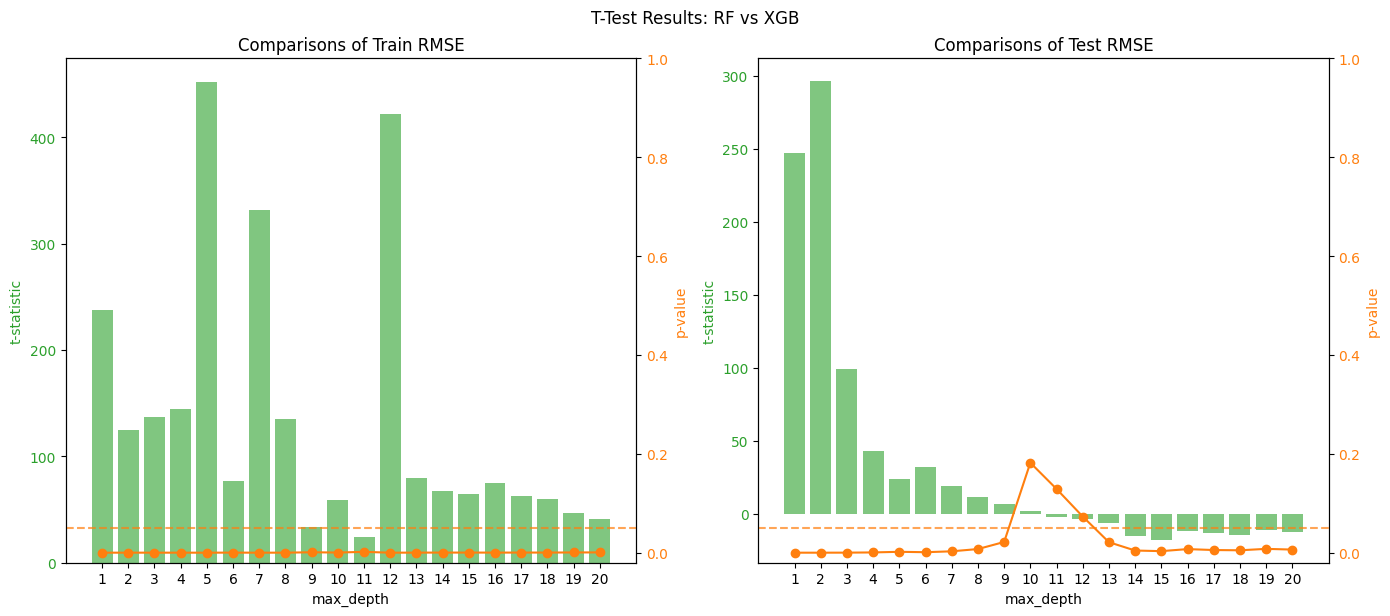

In [ ]:
plot_significance(rf_rmse_train, rf_rmse_test, xgb_rmse_train, xgb_rmse_test, parameter_range, x_label="max_depth", y_label="RMSE")

According to the t-tests, we find that the train RMSE of RF is constantly significantly higher than that of XBF over all values of `max_depth`. Additionally, the test RMSE of RF is significantly higher than that of XBF until `max_depth=9`. From `max_depth=11` on, the XGB receives higher test RMSE with statistical significance, indicating that a high amount of `max_depth` damages the generalization capabilities and therefore out-of-sample performance of XBF.

### Experiment 3: Variation of min_samples_leaf and min_child_weight
For this experiment, we research how regularization can reduce the overfitting for complex models by changing `min_samples_leaf` (RF) and `min_child_weight` (XGB). Orientating ourselves on the results of the `max_depth` experiment, we choose `n_estimators=50` and `max_depth=20` since we know that this creates the biggest gap between in and out-of-sample errors according to the last experiment.

In [ ]:
def run_regularization_experiment(amount_of_iterations, parameter_range, n_estimators, max_depth):
  rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = initialize_arrays(len(parameter_range))

  for seed in range(0, amount_of_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    count = 0
    for i in parameter_range:
      # Fit Random Forest - Using different max_depth
      rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=i, random_state=seed)
      rf_model.fit(X_train, y_train)
      rmse_train, r2_train, rmse_test, r2_test = evaluate_model(rf_model, X_train, y_train, X_test, y_test, print_result=False)
      rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test = add_values(count, rf_rmse_train, rmse_train, rf_r2_train, r2_train, rf_rmse_test, rmse_test, rf_r2_test, r2_test)

      # Fit XGBoost - Using different max_depth
      xgb_model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, min_child_weight=i, random_state=seed)
      xgb_model.fit(X_train, y_train)
      rmse_train, r2_train, rmse_test, r2_test = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, print_result=False)
      xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = add_values(count, xgb_rmse_train, rmse_train, xgb_r2_train, r2_train, xgb_rmse_test, rmse_test, xgb_r2_test, r2_test)
      count += 1

  return rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test

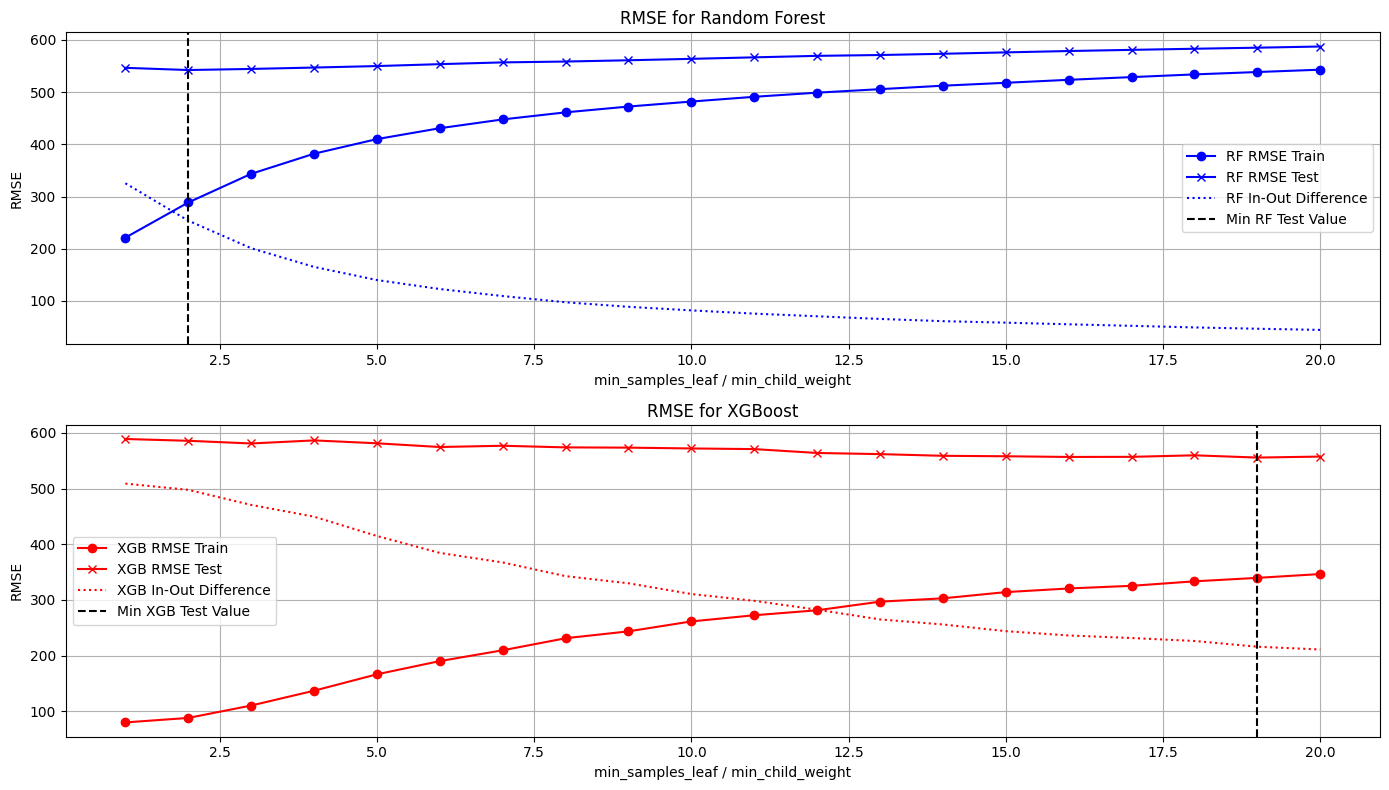

In [ ]:
amount_of_iterations = 30
parameter_range = range(1, 21)
n_estimators = 50
max_depth = 20

rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test = run_regularization_experiment(amount_of_iterations, parameter_range, n_estimators, max_depth)
avg_rf_rmse_train, _, avg_rf_rmse_test, _, avg_xgb_rmse_train, _, avg_xgb_rmse_test, _ = compute_average(rf_rmse_train, rf_r2_train, rf_rmse_test, rf_r2_test, xgb_rmse_train, xgb_r2_train, xgb_rmse_test, xgb_r2_test, amount_of_iterations)

plot_results(avg_rf_rmse_train, avg_rf_rmse_test, avg_xgb_rmse_train, avg_xgb_rmse_test, parameter_range, x_label="min_samples_leaf / min_child_weight", y_label="RMSE")

Based on the plots, we can see that increasing min_samples_leaf for RF and min_child_weight for XBF leads to an increase in in-sample errors.

For RF, the out-of-sample error goes up slightly, but the gap between in-sample and out-of-sample errors is also decreasing. Overall, it can be concluded that increasing the regularization improves the generalization of the model because the gaps shrinks. On the other hand, it is interesting to see that the test RMSE goes up and that the minimum test error happens at `min_samples_leaf=2` where the train RMSE is still very low. This might be because RF tends to have a generalisation gap in general, as can be seen in the `n_estimators` experiment. Further, since we were not able to detect overfitting in the other experiments, it makes sense that the test RMSE does not benefit from regularization in this setting.

For XBF on the other hand, we have detected overfitting in the other experiments. Naturally, we can therefore see a small decrease in test RMSE for higher regularization values, even while the train RMSE goes up significantly. We can therefore say that XBF benefits from high levels of regularization in this setting and that it decreases the overfitting of the model.

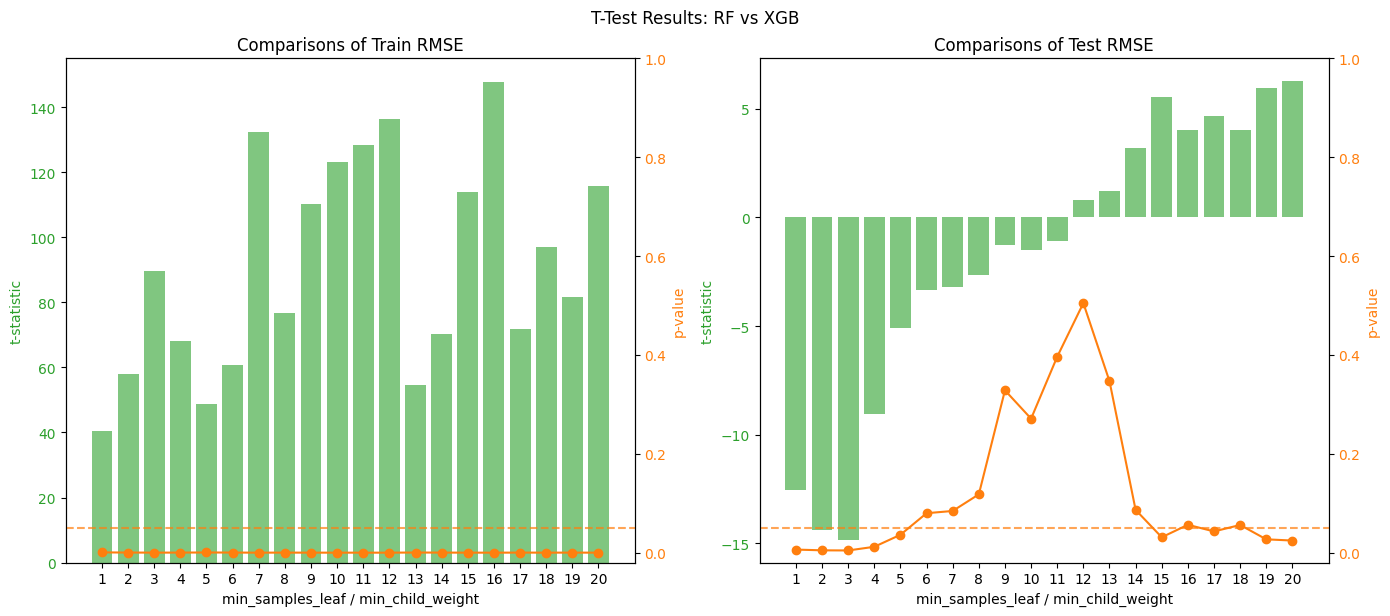

In [ ]:
plot_significance(rf_rmse_train, rf_rmse_test, xgb_rmse_train, xgb_rmse_test, parameter_range, x_label="min_samples_leaf / min_child_weight", y_label="RMSE")

Based on the t-tests, we can say that the train RMSE between XGB and RF are indeed significantly different, such that XGB is consistantly lower than RF.

Regarding the test RMSE, RF performs better until `min_samples_leaf=5`. From `min_samples_leaf=15`, XGB starts taking the lead because overfitting is mitigated with high regularization levels.

## Evaluation of Hypotheses

1. Hypothesis: XGBoost will have slightly lower out-of-sample errors since it is generally considered to be a more powerful model.
>  - We saw that the hyperparameters play a significant role in the performance of both models and that there exist cases where RF performs better than XGB.
>  - When `n_estimators` is low, RF performs better. If it is high, RF and XGB are equal.
>  - When `max_depth` is low, XGB performs better. If it is high and `regularization` is low, RF becomes better because XGB tends to overfit.
>  - When `max_depth` is high and `regularization` is also high, XGB starts outperforming RF again because overfitting is mitigated.
>  - Overall, it can be concluded that the higher complexity of XGB needs to be managed well, e.g. such that overfitting is limited, in order for XGB to show its superior capabilities.
2. Hypothesis: For both model types, models will have _lower_ in-sample errors if their complexity goes up, e.g. if _n\_estimators_ and _max\_depth_ go up.
>  - This has been consistently shown to be true both for the `n_estimators` and `max_depth` experiments.
3. Hypothesis: For both model types, models will show _more_ overfitting, if their complexity goes up, e.g. if _n\_estimators_ and _max\_depth_ go up.
>  - Neither model demonstrated overfitting when `n_estimators` was increased.
>  - For both `n_estimators` and `max_depth` and both model types, it has been shown that the gap between in-sample & out-of-sample errors increases with higher parameter values.
>  - However, RF tends to be less prone to overfitting on this dataset since the out-of-sample error never increases. Instead, the in-sample error further decreases, worsening RF's generalization capabilities.
>  - XGB demonstrated overfitting with high `max_depth`.
4. Hypothesis: For both model types, models will show _less_ overfitting, if their regularization increases, e.g. if _min\_samples\_leaf_ and _min\_child\_weight_ go up.
>  - For RF, since there was no overfitting to begin with, it is hard to draw conclusions about the mitigation of overfitting. However, it's worth mentioning that the gap between in-sample and out-of-sample error is reduced by higher regularization, but also leads to a higher out-of-sample error.
>  - For XGB, the generalization gap and overfitting are indeed mitigated by increasing the regularization of the model.
5. Hypothesis: Random Forests will show _less_ overfitting, since it is a less complex model.
>  - RF did in fact show less overfitting than XGB since the out-of-sample error never started increasing.
>  - On the other hand, RF sometimes showed a big gap between in-sample & out-of-sample errors (e.g. in the `n_estimators` experiment), signalizing generalization problems.
>  - This drives home the fact, that bad generalization and overfiting are indeed two different concepts.
>  - XGB had less generalization problems for the `n_estimators` experiment, but more for the `max_depth` and regularization experiment and also showed overfitting in more instances than RF.

## Limitations
While some statistically significant results have been found, this work is limited by the fact that it only works on one single dataset. Other data might lead to differnt behavior of the models. Furthermore, we saw that different combinations of parameters have a strong influence on the performance. The result might be different if the experiments are repeated with different fixed values, e.g. for a different `max_depth` in case of the regularization experiment.

## Future Work
For further research, we propose to repeat the experiments on several datasets and to consider the task of classification instead of regression. It will also be interesting to investigate the behaviors of different models compared to Random Forests and XGBoost.
In addition, the experiments should be extended to include wider parameter ranges and more parameters in general, e.g. the other regularization parameters of XGBoost, `lambda` and `alpha`.

# <span style='color:blue'>Research Question #3</span>

## Overview

### Research Question

For this section, we will use _Decision Tree Classifiers_ & _KNN Classifiers_ with 2 different datasets:
1. A synthetically generated dataset
2. A real-world, mushroom classification dataset

The **research question** we seek to answer is:


_<center><span style='color:green'>For the datasets and ML algorithms used, how does using “bootstrap aggregation” affect the in-sample & out-of-sample error?_</span></center>

(Note that a definition of bootstrap aggreggation, aka "bagging", can be found in the Appendix of this notebook)

### Strategy

To answer this question, we will perform the following steps for each dataset:
```
1. Repeat 100 times for each model type:
    1. Train 1 base model, and record its in-sample & out-of-sample error
    2. Train ensemble models of various sizes, and record their in-sample & out-of-sample errors
2. Calculate averages
3. Compare the impact of model type & ensemble size on the in-sample & out-of-sample error
```

To estimate _out-of-sample_ error, we will score the performance of our models on "test" data that has not been used for training. Furthermore, in order to further help with our estimates, we will use a different set of 500 training samples for each of the 100 benchmark executions (this might seem strange at first, but we are essentially treating each execution as being in a parallel universe wherein a different set of training samples are available to us from the *full* distribution of all possible samples).

### Hypotheses

Ultimately, we hypothesize the following:
1. For both model types, all **ensemble models** will have **lower** _in-sample_ & _out-of-sample_ errors than their respective base models
2. For both model types, **increasing** the ensemble size will **lower** the _in-sample_ & _out-of-sample_ errors, although with diminishing returns
3. With regards to _out-of-sample_ error, **Decision Trees** will **benefit more** from an ensemble approach than KNN models (since the "look at my neighbors" aspect of KNNs already seems to resemble something similar to an ensemble approach)

## Setup

Before we start answering this question, let's add some helpful python code and data to work with.

### Imports and helper functions

Here are some imports we'll need:

In [ ]:
import math

from IPython.display import display, clear_output
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False


def update_log(message):
    clear_output(wait=True)  # Clear the output area without scrolling
    display(message)  # Display the updated log message

Let's also define some helper functions that we'll be using:

In [ ]:
def plot_decision_boundaries(X, y, model):
    """
    Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting
    the model as we need to find the predicted value for every point in
    scatter plot.

    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model: A pre-trained model
    """
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("Feature-1",fontsize=15)
    plt.ylabel("Feature-2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt


def plot_decision_boundaries_comparison(X, y, model_1, model_2):
    """
    Function to plot the decision boundaries of two different
    classification models side-by-side.
    """
    # Create a new figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the first decision boundary
    plt.sca(axes[0])  # Set the current axis to the first subplot
    axes[0].set_title('Baseline Decision Boundary')  # Set title for the first subplot
    plot_decision_boundaries(X_train, y_train, pipeline)

    # Plot the second decision boundary
    plt.sca(axes[1])  # Set the current axis to the first subplot
    axes[1].set_title('Ensemble Decision Boundary')  # Set title for the first subplot
    plot_decision_boundaries(X_train, y_train, bagging_classifier)

    plt.subplots_adjust(wspace=0.5)  # Add space between subplots horizontally
    # plt.tight_layout()  # Adjust layout to prevent overlap


def plot_errors(n_estimators_list, all_errors, title='Error rates vs. Number of estimators'):

    # Calculate average errors
    avg_errors = {n: {key: np.mean(values) for key, values in errors.items()} for n, errors in all_errors.items()}

    # Prepare data for plotting
    n_estimators_list = list(avg_errors.keys())
    in_errors = [avg_errors[n]['in'] for n in n_estimators_list]
    out_errors = [avg_errors[n]['out'] for n in n_estimators_list]
    bagging_in_errors = [avg_errors[n]['bagging_in'] for n in n_estimators_list]
    bagging_out_errors = [avg_errors[n]['bagging_out'] for n in n_estimators_list]

    # Plot the errors
    plt.figure(figsize=(8, 4))
    plt.plot(n_estimators_list, in_errors, 'b--', label='Baseline in-sample error')  # Added 'o' for markers
    plt.plot(n_estimators_list, bagging_in_errors, 'b-o', label='Bagging in-sample error')  # Added 'o' for markers
    plt.plot(n_estimators_list, out_errors, 'r--', label='Baseline out-of-sample error')  # Added 'o' for markers
    plt.plot(n_estimators_list, bagging_out_errors, 'r-o', label='Bagging out-of-sample error')  # Added 'o' for markers
    plt.xlabel('Number of estimators')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Synthetic Dataset

Now, let's create a synthetic dataset for classification. To do so, we will _first_ generate a distribution of 50k data points, and then randomly select 500 to be "training" samples that are available to us. The reason for generating such a large number of data points and using only 1% of them is 2-fold:
1. Having a large number of data points that _aren't_ used for training will be useful for estimating out-of-sample error.
2. Using a small number of data points for training will allow us to train our models within a reasonable amount of time

We will generate a distribution that with 2 features and 2 classes, and we will have them be _somewhat_ linearly separable, albeit with overlap:

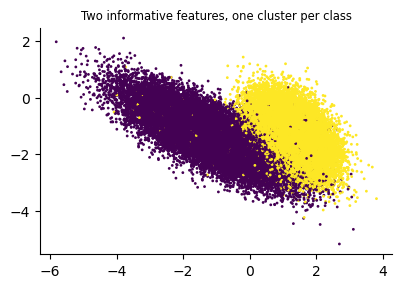

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(322)
plt.title("Two informative features, one cluster per class", fontsize="small")
X, y = make_classification(
    n_samples=50000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, class_sep=1.3, random_state=20
)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=1)

plt.show()

### Defining our benchmark functions

Now we will define the benchmarking code that we plan to run multiple times. This code will do the following:
1. Train 1 base model, and record its in-sample & out-of-sample error
2. Train ensemble models of various sizes, and record their in-sample & out-of-sample errors

In [ ]:
def benchmark(X_train, y_train, X_test, y_test, model, n_estimators_in_ensemble=10, random_state=42):

    # Train base model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    # In-sample & out-of-sample error
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    in_error = 1 - accuracy_score(y_train, y_train_pred)
    out_error = 1 - accuracy_score(y_test, y_test_pred)

    # Train bagging classifier
    bagging_classifier = BaggingClassifier(estimator=pipeline, n_estimators=n_estimators_in_ensemble,
                                           random_state=random_state)
    bagging_classifier.fit(X_train, y_train)

    # Begging in-sample & out-of-sample error
    y_train_pred = bagging_classifier.predict(X_train)
    y_test_pred = bagging_classifier.predict(X_test)
    bagging_in_error = 1 - accuracy_score(y_train, y_train_pred)
    bagging_out_error = 1 - accuracy_score(y_test, y_test_pred)

    return in_error, out_error, bagging_in_error, bagging_out_error


def run_decision_tree_benchmarks(X, y, n_estimators_list=[2, 5, 10, 50], num_executions=30):

    # Store in-sample and out-of-sample errors for baseline and each bag size
    all_errors = {n: {'in': [], 'out': [], 'bagging_in': [], 'bagging_out': []} for n in n_estimators_list}

    for i in range(num_executions):
        update_log(f'Running benchmark execution {i+1} of {num_executions}...')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=i)
        for n_estimators in n_estimators_list:
            in_error, out_error, bagging_in_error, bagging_out_error = benchmark(X_train, y_train,
                                                                                 X_test, y_test,
                                                                                 DecisionTreeClassifier(random_state=i),
                                                                                 n_estimators_in_ensemble=n_estimators,
                                                                                 random_state=i)
            all_errors[n_estimators]['in'].append(in_error)
            all_errors[n_estimators]['out'].append(out_error)
            all_errors[n_estimators]['bagging_in'].append(bagging_in_error)
            all_errors[n_estimators]['bagging_out'].append(bagging_out_error)

    update_log(f'Finished running benchmarks!')
    return all_errors


def run_knn_benchmarks(X, y, n_estimators_list=[2, 5, 10, 50], num_executions=30):

    # Store in-sample and out-of-sample errors for baseline and each bag size
    all_errors = {n: {'in': [], 'out': [], 'bagging_in': [], 'bagging_out': []} for n in n_estimators_list}

    for i in range(num_executions):
        update_log(f'Running benchmark execution {i+1} of {num_executions}...')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=i)
        for n_estimators in n_estimators_list:
            in_error, out_error, bagging_in_error, bagging_out_error = benchmark(X_train, y_train,
                                                                                 X_test, y_test,
                                                                                 KNeighborsClassifier(n_neighbors=round(np.sqrt(len(X_train)))),
                                                                                 n_estimators_in_ensemble=n_estimators,
                                                                                 random_state=i)
            all_errors[n_estimators]['in'].append(in_error)
            all_errors[n_estimators]['out'].append(out_error)
            all_errors[n_estimators]['bagging_in'].append(bagging_in_error)
            all_errors[n_estimators]['bagging_out'].append(bagging_out_error)

    update_log(f'Finished running benchmarks!')
    return all_errors

## Experiment with synthetic data

### Benchmarking Decision Tree "Bagging"

Let's now benchmark the error rates of Decision Tree Ensembles of various sizes for our synthetic dataset. Note that for this particular research question, we will not focus on hyperparameter tuning, and will instead just use the default values (we will discuss the implications of this later on):

'Finished running experiments!'

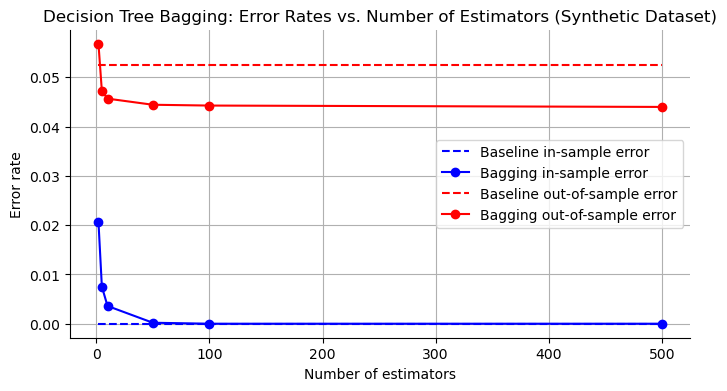

In [ ]:
n_estimators_list = [2, 5, 10, 50, 100, 500]
all_errors = run_decision_tree_benchmarks(X, y, n_estimators_list=n_estimators_list, num_executions=30)

# Plot results
plot_errors(n_estimators_list, all_errors, title='Decision Tree Bagging: Error Rates vs. Number of Estimators (Synthetic Dataset)')

From this plot, we can make the following _out-of-sample_ observations about using Decision Tree "bagging" for the synthetic data distribution we generated:
- **Increasing** the number of models in our ensemble tends to **lower** the _out-of-sample_ error
- **At least a few estimators** are needed in our ensemble in order to beat the _out-of-sample_ performance of a single Decision Tree

We can also make the following _in-sample_ observations:
- **Increasing** the number of models in our ensemble tends to **lower** the _in-sample_ error
- A **single Decision Tree** has a **lower** _in-sample_ error than seemingly any of the ensembles

To help provide context for these results, let's pick a random Decision Tree and ensemble, and plot their decision boundaries:

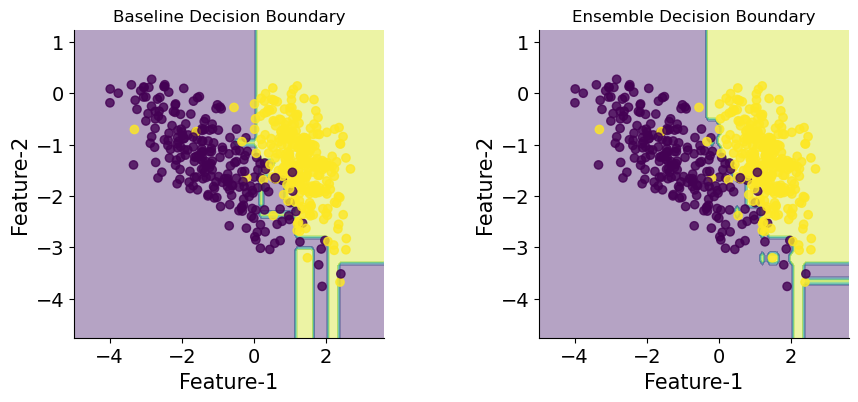

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=2)

# Train base model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=2))
])
pipeline.fit(X_train, y_train)

# Train ensemble model
bagging_classifier = BaggingClassifier(estimator=pipeline, n_estimators=50,
                                       random_state=2)
bagging_classifier.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_boundaries_comparison(X_train, y_train, pipeline, bagging_classifier)

From the above, it appears as though the baseline Decision Tree (left) has decision boundaries that fit the training samples in very specific ways, but which perhaps don't generalize well.

Conversely, the ensemble (right) has decision boundaries that seem more smooth and capable of generalizing to unseen samples.

### Benchmarking KNN "Bagging"

Now let's benchmark the error rates of KNN ensembles of various sizes for our synthetic dataset. Note that, since we don't want to try out all possible K values (the number of "neighbors" to look at when classifying new samples), we will simply set K equal to the square root of the number of training samples, mainly since this often seems to be a decent value to start with, according to various online sources (we discuss the implications of this later on):

'Finished running experiments!'

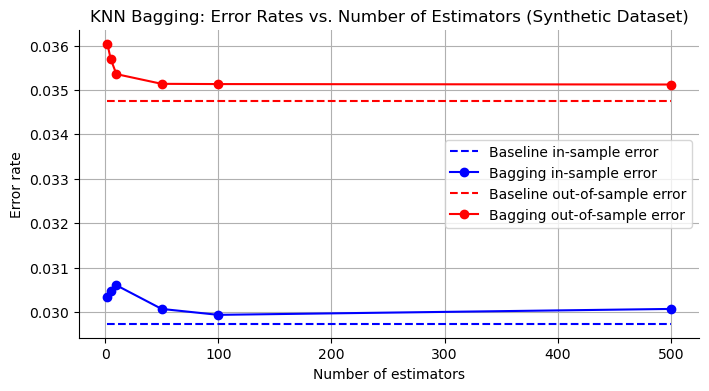

In [ ]:
n_estimators_list = [2, 5, 10, 50, 100, 500]
all_errors = run_knn_benchmarks(X, y, n_estimators_list=n_estimators_list, num_executions=30)

# Plot results
plot_errors(n_estimators_list, all_errors, 'KNN Bagging: Error Rates vs. Number of Estimators (Synthetic Dataset)')

From this plot, we can make the following _out-of-sample_ observations about using KNN "bagging" for the synthetic data distribution we generated:

- **Increasing** the number of models in our ensemble tends to **lower** the _out-of-sample_ error
- **Bagging** seems to consistently yield a **worse/higher** _out-of-sample_ error than when using a single KNN model

We can also make the following _in-sample_ observations:
- **Increasing** the number of models in our ensemble tends to **lower** the _in-sample_ error **up until** a certain number of estimators, but then starts to get **worse/higher** again
- A **single KNN model** has a **lower** _in-sample_ error than any of the ensembles

Similar to what we did for Decision Trees, let's see if we can perhaps provide visual context for these results by plotting the decision boundaries for an arbitrary KNN model and arbitrary KNN ensemble model (both trained on the same dataset we've been using)

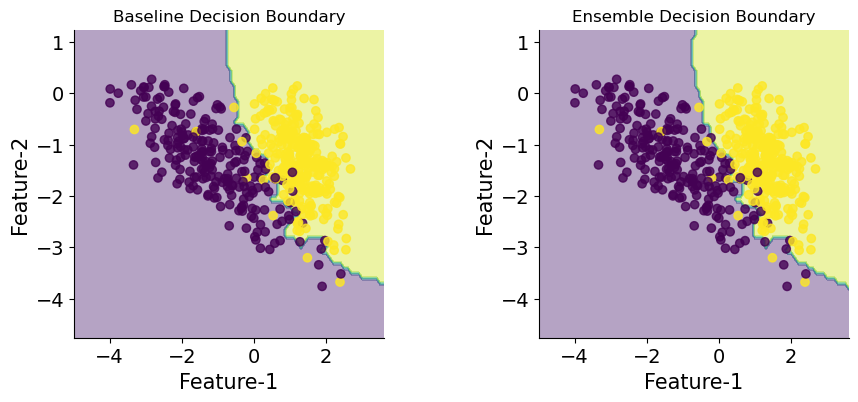

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=2)

# Train base model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])
pipeline.fit(X_train, y_train)

# Train ensemble model
bagging_classifier = BaggingClassifier(estimator=pipeline, n_estimators=50,
                                       random_state=2)
bagging_classifier.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_boundaries_comparison(X_train, y_train, pipeline, bagging_classifier)

Unlike in the Decision Tree example, these KNN decision boundaries unfortunately seem a bit more difficult to draw insights from (both are quite smooth and have similar boundary positions that are difficult to discern).

Taking a step back, we've managed to make a few observations about how the _in-sample_ and _out_of_sample_ error rates are affected by "bagging" for this particular dataset and set of model types. But perhaps we might see different results if we were to use other sources of data governed by different statistical qualities. While we will save a truly deep exploration of this matter for another time, one thing we _can_ do relatively easily right now is examine an arbitrary real-world classification dataset. Let's do that!

## Experiment with real-world "Mushroom" data

For this next section, we will turn our attention towards real-world "mushroom" classification data. The data we'll be drawing from also consists of ~50k samples in total, and we will again be treating 500 of those as training samples, and the rest as a proxy for "out-of-sample" data points.

**Note**: this "mushroom" data is meant for classifying whether mushrooms are poisonous or not. However, for this research question, we won't be exploring the issue of false negatives being _much worse_ than false positives (although there are certainly some interesting research questions that could be explored with regards to that!)

Let's proceed to import this dataset:

In [ ]:
import pandas as pd

# If downloading the mushroom dataset CSV file from github doesn't work, it can also
# be downloaded from Kaggle: https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset,
# and then loaded using the commented-out line of code below.
# df = pd.read_csv("mushroom_cleaned.csv")

# Load mushroom dataset from Github
url = "https://raw.githubusercontent.com/seanscofield/sfml-project/main/data/mushroom_cleaned.csv"

df = pd.read_csv(
    url,
    sep=',',
    encoding='utf-8',
)


# Extract features (X) and target (y) columns from the DataFrame
X = df.drop(columns=['class'])  # Drop the 'class' column to get features
y = df['class']  # Get the 'class' column as the target

# Optionally, you may convert X and y to NumPy arrays if needed
X = X.values
y = y.values

To provide context for the data that has been loaded, we can inspect the first few records in it:

In [ ]:
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,2
1,1461,2,2,10,3.807467,1557,11,1.804273,2
2,1371,2,2,10,3.612496,1566,11,1.804273,2
3,1261,6,2,10,3.787572,1566,11,1.804273,2
4,1305,6,2,10,3.711971,1464,11,0.943195,2


Very cool!

Let's also spot check the correlations between these features and the target label (the "class" item). Since we are not training as powerful models here as we were previously (with XGBoost and RandomForests, which can require a lot of training time), we will most likely keep all of the features unless we see some features that are _extremely highly_ correlated with one another, or _barely_ correlated with the target:

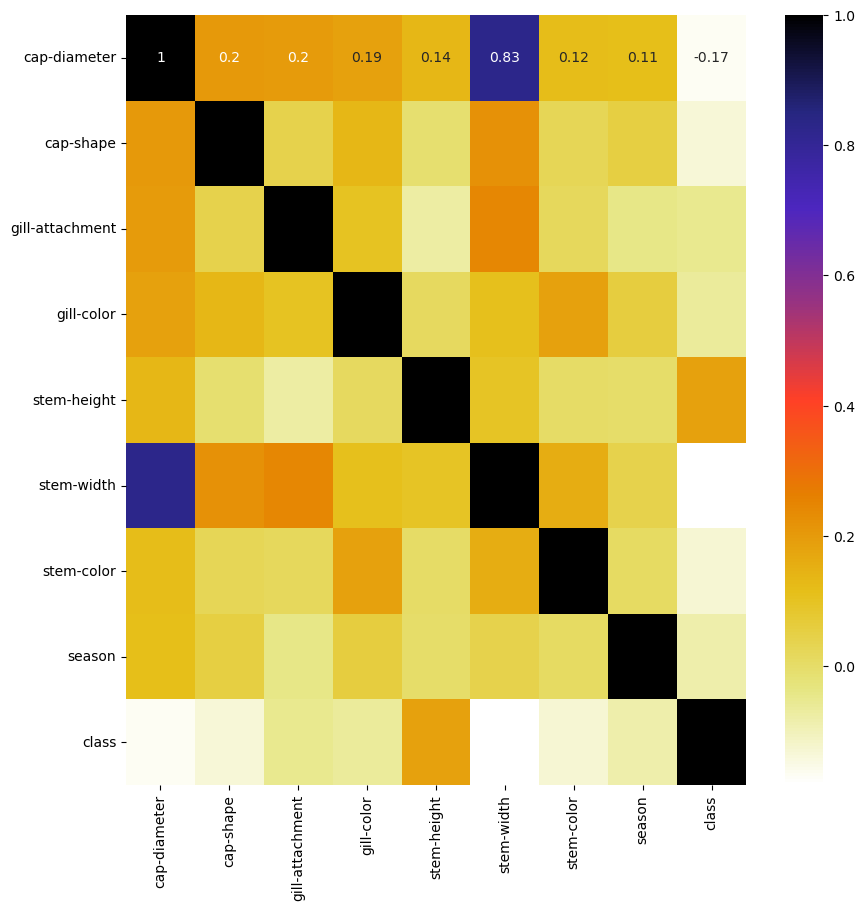

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

From the looks of this, there is nothing strikingly in need of removing. Let's now perform the same benchmarking that we did for our synthetic data. We'll start by examining the error rates that arise when using "bagging" with Decision Trees on this mushroom data:

'Finished running experiments!'

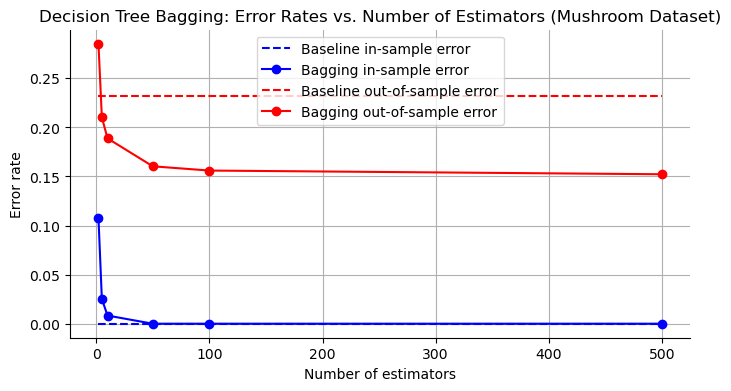

In [ ]:
n_estimators_list = [2, 5, 10, 50, 100, 500]
all_errors = run_decision_tree_benchmarks(X, y, n_estimators_list=n_estimators_list, num_executions=30)

# Plot results
plot_errors(n_estimators_list, all_errors, title='Decision Tree Bagging: Error Rates vs. Number of Estimators (Mushroom Dataset)')

From the above, we can see trends that are very similar to what we saw with our synthetic dataset, without any strikingly noticeable differences. It could potentially be fun and useful to try to plot some decision boundaries with this new mushroom dataset (like we did before), but doing so is less reasonable for this higher-dimensional dataset (we could perform feature reduction to yield 2 features, but that doesn't seem particularly useful here).

Let's now turn our attention back to KNN:

'Finished running benchmarks!'

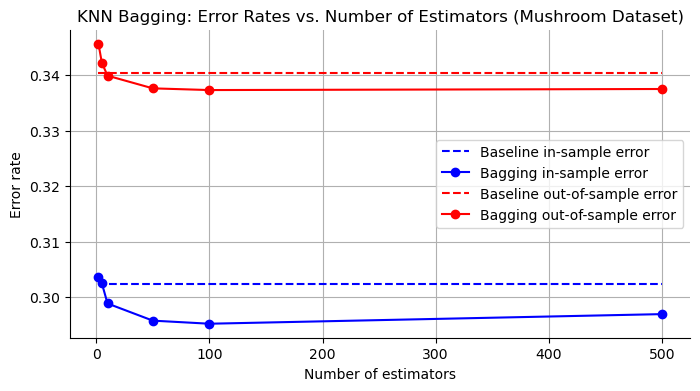

In [ ]:
n_estimators_list = [2, 5, 10, 50, 100, 500]
all_errors = run_knn_benchmarks(X, y, n_estimators_list=n_estimators_list, num_executions=30)

# Plot results
plot_errors(n_estimators_list, all_errors, 'KNN Bagging: Error Rates vs. Number of Estimators (Mushroom Dataset)')

From the above, we see a somewhat similar behavior with regards to what we saw for KNN _in-sample_ error with our synthetic dataset. However, for _out-of-sample_ error, we now have a situation in which "bagging" _did_ improve the overall performance (unlike before). We will discuss more of our thoughts on this further on in this notebook.

## Evaluation of hypotheses

We have seen some interesting experiment results so far! Let's now return to our original hypotheses for this research question in order to evaluate them using what we've learned:

1. Hypothesis: For both model types, all **ensemble models** will have **lower** _in-sample_ & _out-of-sample_ errors than their respective base models

> What actually happened: This turned out to be _false_. For starters, the _in-sample_ error seemed to consistently be lower for the baseline models than for their bagging counterparts (until a large number of estimators were used, which then made the error rate about equal to that of the baseline model). In addition, "bagging" only seemed to consistently improve/lower the _out_of_sample_ error for Decision Trees, and even then, there was a minimum number of estimators needed before that was the case (e.g. 2 estimators was not enough). For KNNs, we only saw a lowering in out-of-sample error for our Mushroom dataset (and again, only when using more than a small handful of estimators).
>
> Interpretation: Regarding the _in-sample_ error, we suspect in hindsight that the baseline models are able to better learn the in-sample data characteristics than ensemble models that have few estimators because of the fact that the estimators are trained on data points that were sampled _with replacement_ (which might literally mean that, unless there are enough estimators, the ensemble has not actually seen all of the available training data yet). We also suspect that the _out-of-sample_ error was higher for ensembles with few estimators than for their respective baseline models for the same reason. Lastly, we think that KNNs perhaps don't benefit as much from "bagging" in this context due to a perceived similarity between "bagging" and observing multiple "nearest neighbors" (in both situations, classification is happening as a result of majority vote). Perhaps using a smaller K value might cause different results for this reason. We also wonder if certain aspects of the mushroom data (e.g. higher-dimensionality) might be worth exploring with regards to potentially being more ripe for "bagging" with KNNs.

2. Hypothesis: For both model types, **increasing** the ensemble size will **lower** the _in-sample_ & _out-of-sample_ errors, although with diminishing returns

> What actually happened: This turned out to be _partially false_. Specifically, increasing the ensemble size did seem to lower the _out-of-sample_ error for both model types (albeit with diminishing returns), but for KNNs, the _in-sample_ error initially became worse/higher until the number of estimators was increased somewhere beyond 10, and then proceeded to get lower until somewhere near or beyond 100, and then started going back up again.
>
> Interpretation: We are not entirely sure how to explain the changes in _in-sample_ error as the number of estimators changes. That being said, our best guess to explain part of that behavior is that somehow, when too many estimators are used, they are no longer diverse enough to be as useful (perhaps only so many diverse estimators can be trained from a limited dataset before some start to become similar to others). This makes us wonder if perhaps the same behavior would be seen with Decision Tree bagging if we increased the number of estimators high enough.

3. Hypothesis: With regards to _out-of-sample_ error, **Decision Trees** will **benefit more** from an ensemble approach than KNN models

> What actually happened: This turned out to be _true_ for our particular datasets and models.
>
> Interpretation: Similar to what has been mentioned previously, this perhaps suggests that the inherent nature of KNNs to perform a majority vote using multiple "nearest neighbors" is too similar to the notion of "bagging" for the latter to provide further improvements. It might be for this very reason that Decision Trees benefit more from "bagging" than KNNs in the context of classification problems.

## Limitations

Overall, the interpretations that we've made for each of our hypotheses are heavily tied to the _particular datasets_ (as well as the amount of data used for training) that we've used here, and it is difficult to draw grand conclusions about the general behaviors of KNN classification and Decision Tree classifcation with "bagging". Perhaps using datasets with different charasteristics from these ones would yield different results.
  
In addition, it's also worth noting that we didn't really explore how "bagging" might affect a scenario in which different hyperparameter values are used for our Decision Trees, or various different K values for our KNNs. It could be that when varying those things, we might see different results.

## Future Work

In terms of future work that we would like to tackle, we think it would be most interesting to perform this experiment with more varied datasets governed by different statistical qualities, as well as different _amounts_ of training data. We would also like to dig deeper into analyzing whether the impact of "bagging" can be visibly increased or decreased depending on the model hyperparameters. In particular, exploring whether KNN benefits more from "bagging" when a smaller K value seems like a rather useful avenue of exploration.

# <span style='color:blue'>Appendix</span>

## ML Models & Important Terms

### K-Nearest Neighbor (KNN)

The K-Nearest Neighbor algorithm (KNN) is a supervised lazy learning algorithm. It determines the classification/value of an unknown datapoint as follows.


Let
$$
\{(x_n, y_n) : x_n \in \mathbb{R}^d \text{ and } y_n \in \{-1, 1\}\}
$$


be the training set with n = 1, ..., N. Given the size of a vector ||.|| on $\mathbb{R}^d$ and a new datapoint $x \in \mathbb{R}^d$, the KNN algorithm will reorden the training set into $\{(X_1, Y_1), ..., (X_n, Y_n)\}$ such that $||X_1 - x|| \leq ... \leq ||X_n - x||$, we will call this set Z.


Let k be a positive, non-null integer. K represents the amount of neighbors we want to include in the classification/regression. KNN will select the first K elements in Z (by how Z is constructed these will be the k-nearest elements to x) for its consideration when determining the value of x.
For classification, KNN assigns the most common class found in the k-nearest neighbors of x as the class of x.
For regression, KNN will take the average-value of the k-nearest neighbors of x as the property value of x.

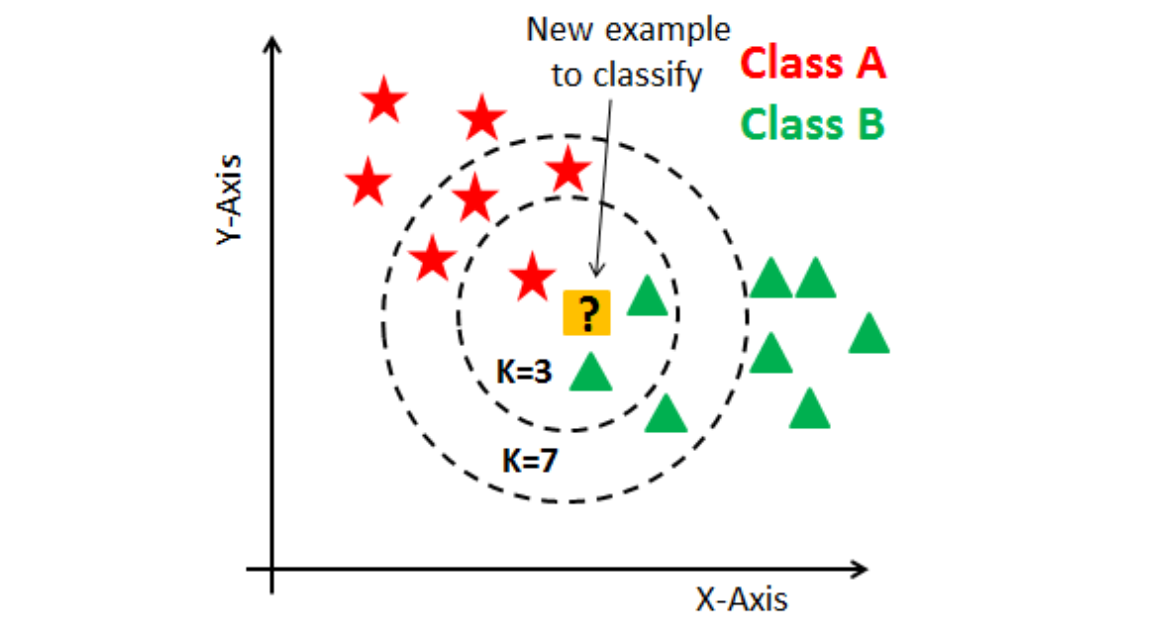

Image Source: [Medium](https://rajviishah.medium.com/introduction-to-k-nearest-neighbors-knn-algorithm-e8617a448fa8)

When transforming this into an algorithm, the steps would be as follows:
1. **Get a datapoint that requires a property value x**
2. **Determine the distance between x and each of the datapoints used to "train" the model**
3. **Select the k-closests datapoints to x, refered to as Z**
4. **Determine the property value of x**
  1. **Classification:** Property value of x becomes the most common class found in Z
  2. **Regression:** Property value of x becomes the average of all the values found in Z


A slightly different version of KNN for classification and regression can be to assign weights to the contribution of neighbors, called weighted KNN. This allows for closer neighbors to have a larger impact on the result compared to more distant ones. To achieve this weighted KNN implements a weighting scheme, an example of which could be linear inversely proportional by adding a weight of $\frac{1}{d}$, with d being the distance between x and the neighbor. Using a bagging method might also cause a form of artificial weighting, as some datapoints might occur multiple times as a neighbour.

### Decision Tree

#### Overview

A Decision Tree is a machine learning model in which a tree-like decision-making structure is used in order to make predictions. For our purposes here, we will focus on using Decision Trees for classification problems rather than regression problems, although they can be used for both. For classification problems, a Decision Tree is usually represented in such a way that:
- Each node tests an attribute
- Each branch corresponds to a range of attribute values
- Each leaf node assigns a classification

Here is a visual representation of a simple example (image was downloaded from [here](https://slideplayer.com/slide/13079902/79/images/9/Decision+Tree+for+PlayTennis.jpg)):

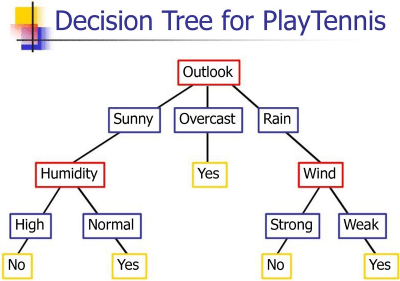

In the above example, a Decision Tree is used in order to make predictions about whether a given day is a good day to play tennis (based on various weather conditions).

**Note**: while this particular example doesn't have any numerical attributes, those types of attributes can still be reasoned about by splitting the test data into buckets based on threshold values, and then "categorizing" new values into those buckets accordingly. The decisions about where to split are often determined using criteria like information gain (described further on), in which all possible splits are examined in order to find the one that results in the most homogeneous subsets.

#### Construction of a Decision Tree

While there are multiple ways to build a Decision Tree classifier, one of the most common strategies is to use _information gain_ (as related to the concept of _entropy_)

**Entropy** quantifies the level of unpredictability present in random variables. In a dataset, it can be used to quantify the unpredictability/variability of the target feature. For example, in binary classification, the entropy is 0 if the target feature is homogenous and 1 if the target feature has an equal number of both classes. It can be calculated as follows:

$$
\text{Entropy}(S) = - \sum_{i=1}^{n} p_i \log_2(p_i)
$$

**Information Gain** calculates the reduction in the _entropy_ and measures how well a given feature separates or classifies the target classes. The feature with the highest Information Gain is selected as the best one. It can be calculated as follows:

$$
IG(S, A) = \text{Entropy}(S) - \sum_{v} \left( \frac{|S_v|}{|S|} \cdot \text{Entropy}(S_v) \right)
$$

One advantage of using information gain to build Decision Trees is that "it tends to choose the most impactful features that are close to the root of the tree. It is a very good measure for deciding the relevance of some features." (Source: [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree)).

Ultimately, a typical algorithm for building a Decision Tree using information gain is as follows:
```
1. Start with the entire training dataset S
2. Main loop:
  3. Calculate the information gain for each feature.
  4. Make a new node using the feature with the maximum information gain.
  5. Split the current set of data into further subsets using this feature.
  6. If the current set of data can't be divided further, then all
     remaining samples in this set belong to the same class, and we
     should create a leaf node with the class as its label.
  7. Otherwise, we should repeat this process for each of the remaining
     features and their corresponding subsets of data
```

### Bootstrap Aggregation ("Bagging")

#### Overview

Bootstrap aggregation refers to creating an ensemble model by combining multiple models that have each been trained on a random subset of available training data (sampled _with replacement_). Some commonly-used strategies for decision-making within an ensemble are averaging and majority-vote (for regression and classification problems, respectively)  

Ultimately, bootstrap aggregation is often leveraged to improve the stability & accuracy of ml algorithms, as well as to reduce variance and help avoid overfitting.

Here is a visual example of bagging (sourced from [here](https://tupleblog.github.io/images/post/baggingboosting/schematic.png)):

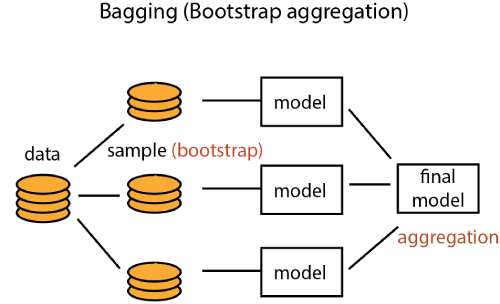

#### Sampling with replacement

Typically, we want each of the models within our ensemble to be trained on the same number of samples as our training set, but instead of using that exact same set of samples, we instead sample _with replacement_ the same number of samples from that set. Here is a visual example:

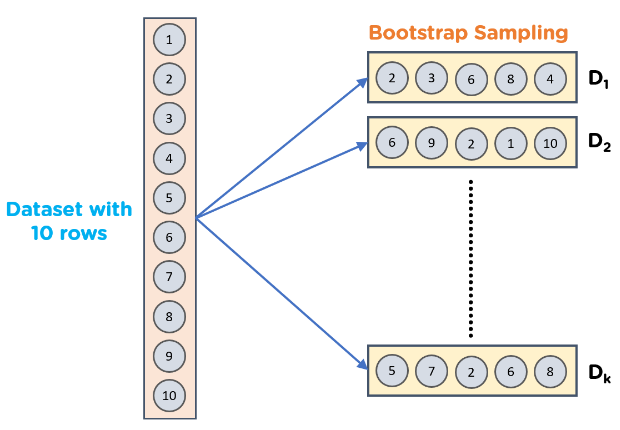

#### Prediction with a Decision Tree

An algorithm for classifying a sample using a Decision Tree can be summarized as follows:
```
1. Starting at the root node, repeat the following until we have reached a leaf node:
  2. For whichever attribute the current node is testing, read the corresponding value from this sample.
  3. Make a decision about which branch to take depending on that value (e.g. is the value for the Outlook attribute "Sunny", "Overcast", or "Rainy"?).
  4. Follow the corresponding branch to the next node.
5. Return the classification of the leaf node we are at.
```

Here is a visual example of calculating the information gain for a feature when starting at the root node (adapted from slides from the VUB ML Bachelor's course):

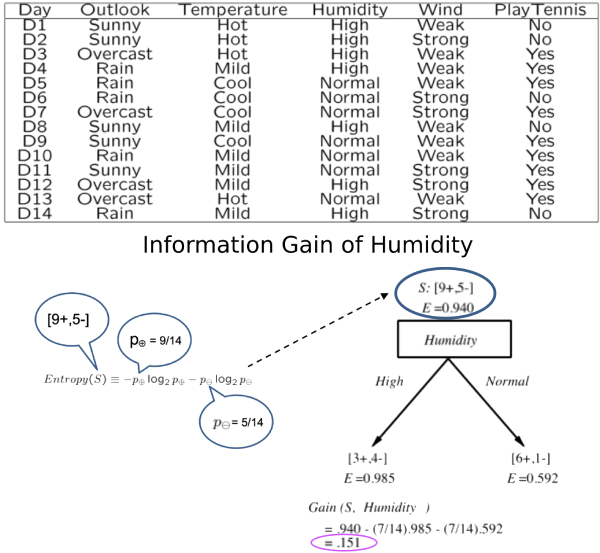


### Random Forest (RF)

The Random Forest algorithm is an ensemble learning method for classification and regression tasks. It constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. It improves accuracy and controls overfitting by combining multiple models.

#### Construction of a Random Forest

Given a training set $\{(x_n, y_n) : x_n \in \mathbb{R}^d \text{ and } y_n \in \{-1, 1\}\}$ with $n = 1, \ldots, N$, the process of building a Random Forest is as follows:

1. **Bootstrap Sampling**:
    - Generate $B$ bootstrap samples $\{S_b\}$ from the original training set. Each sample $S_b$is created by randomly sampling $N$ instances from the training set with replacement.

2. **Training Individual Trees**:
    - For each bootstrap sample $S_b$, construct a decision tree $T_b$. During the construction of $T_b$, at each node:
        - Select a subset of $m$ features randomly from the $d$ features. Typically, $m \approx \sqrt{d}$ for classification and $m \approx d/3$ for regression.
        - Choose the best split among the $m$ features using a splitting criterion (e.g., Gini impurity for classification, mean squared error for regression).
        - Continue splitting nodes until a stopping criterion is met (e.g., maximum depth, minimum number of samples at a node).

  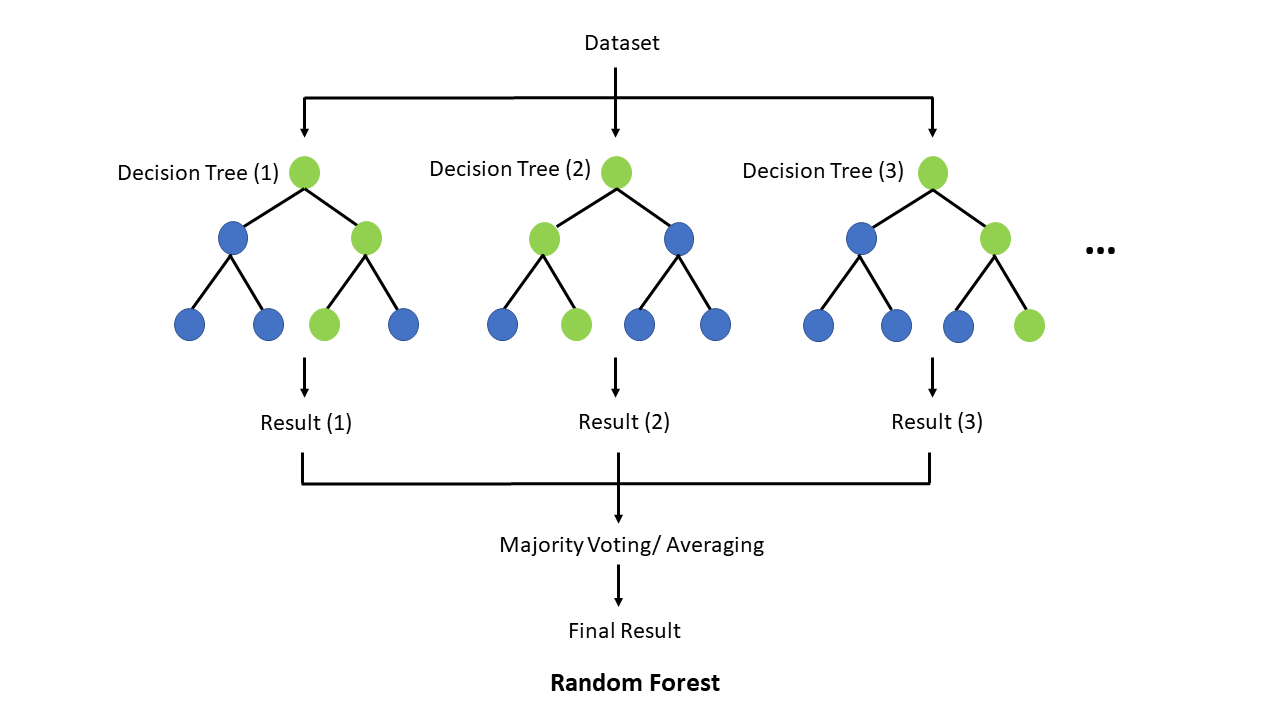

Image Source: [Wikipedia](https://wikipedia.org/wiki/Random_Forest)


#### Prediction with a Random Forest

Once the Random Forest is constructed, predictions can be made for a new data point $x \in \mathbb{R}^d$as follows:

1. **Classification**:
    - Pass $x$through each of the $B$ decision trees $T_b$. Each tree outputs a class label $C_b(x) \in \{-1, 1\}$.
    - Aggregate the class labels from all trees and assign the class with the majority vote as the final prediction for $x$:
      $\hat{y} = \text{mode}(\{C_1(x), C_2(x), \ldots, C_B(x)\})$

2. **Regression**:
    - Pass $x$ through each of the $B$ decision trees $T_b$. Each tree outputs a predicted value $R_b(x) \in \mathbb{R}$.
    - Aggregate the predicted values from all trees and assign the average value as the final prediction for $x$:
      $\hat{y} = \frac{1}{B} \sum_{b=1}^{B} R_b(x)$

#### Advantages of Random Forests

- **Accuracy**: Random Forests typically achieve higher accuracy than individual decision trees due to the aggregation of multiple models.
- **Robustness**: They are less prone to overfitting compared to single decision trees.
- **Versatility**: They can handle both classification and regression tasks and can be used for feature importance estimation.

### XGBoost


XGBoost (Extreme Gradient Boosting) is an advanced implementation of gradient boosting designed for speed and performance. It builds an ensemble of decision trees sequentially, where each new tree aims to correct the errors of the previous trees. It uses a gradient descent algorithm to minimize the loss function.

#### Construction of an XGBoost Model

Given a training set $\{(x_n, y_n) : x_n \in \mathbb{R}^d \text{ and } y_n \in \mathbb{R}\}$ with $n = 1, \ldots, N$, the construction of an XGBoost model involves the following steps:

1. **Initialization**:
    - Initialize the model with a constant prediction $\hat{y}^{(0)}$, usually the mean of $y$ for regression:
      $\hat{y}^{(0)} = \frac{1}{N} \sum_{n=1}^{N} y_n$

2. **Additive Training**:
For $t = 1, \ldots, T$ (where $T$ is the total number of trees):
- Compute the gradient (first derivative) of the loss function with respect to the predictions $\hat{y}_n^{(t-1)}$:

$$
g_n^{(t)} = \left. \frac{\partial L(y_n, \hat{y}_n)}{\partial \hat{y}_n} \right|_{\hat{y}_n = \hat{y}_n^{(t-1)}}
$$
- Compute the hessian (second derivative) of the loss function with respect to the predictions $\hat{y}_n^{(t-1)}$:

$$
h_n^{(t)} = \left. \frac{\partial^2 L(y_n, \hat{y}_n)}{\partial \hat{y}_n^2} \right|_{\hat{y}_n = \hat{y}_n^{(t-1)}}
$$

- Fit a decision tree $f^{(t)}(x)$ to the gradients $g_n^{(t)}$ and hessians $h_n^{(t)}$. The tree's structure is determined by minimizing the loss function.
- Update the predictions:
    $$
    \hat{y}_n^{(t)} = \hat{y}_n^{(t-1)} + \eta f^{(t)}(x_n)
    $$
    where $\eta$ is the learning rate.

#### Prediction with XGBoost

Once the model is trained, predictions for a new data point \(x \in \mathbb{R}^d\) are made by summing the contributions of all trees. The prediction is updated incrementally by adding the weighted output of each tree to the current prediction. The final prediction is given by:
$$
\hat{y}(x) = \hat{y}^{(0)} + \sum_{t=1}^{T} \eta f^{(t)}(x)
$$
where $\hat{y}^{(0)}$ is the initial prediction (often the mean of the target values for regression), $f^{(t)}(x)$ is the output of the $t$-th tree, and $\eta$ is the learning rate which scales the contribution of each tree.

#### Loss Function

The loss function $L$ used in XGBoost typically includes both the primary objective (e.g., mean squared error for regression, log loss for classification) and the regularization term $\Omega(f)$:

$$
L(\{y_n\}, \{\hat{y}_n\}) = \sum_{n=1}^{N} \ell(y_n, \hat{y}_n) + \sum_{t=1}^{T} \Omega(f^{(t)})
$$

#### Advantages of XGBoost

- **Efficiency**: XGBoost is designed for computational efficiency, with optimizations such as parallelized tree construction and cache-aware access patterns.
- **Regularization**: It incorporates both L1 and L2 regularization, which help to prevent overfitting.
- **Handling Missing Values**: XGBoost can handle missing values internally by learning the best imputation strategy.